# chips-net analysis

This notebook contains the full analysis of chipsnet showing the full path taken to the final version...

## Finding the best models
- [x] [Exploring the data](#explore)
- [x] [Which image representation is best?](#repr)
- [x] [Which channel configuration is best?](#channel)
- [x] [Which training sample is best?](#sample)
- [x] [Which categorisation is best?](#cat)
- [x] [Does vertex help cosmic classifier?](#cosmic)
- [x] [Does primary count help beam classifier?](#beam)
- [x] [Does lepton energy help neutrino energy estimation?](#energy)
- [x] [Different sample energy estimation](#energy_samples)
- [ ] [Final performance and comparison with old reco/pid](#final)

## Explainability and resilience
- [ ] [Model calibration sensitivity: cosmic classification](#cosmic_calib)
- [ ] [Model calibration sensitivity: beam classification](#beam_calib)
- [ ] [Model calibration sensitivity: energy estimation](#energy_calib)
- [ ] [Clustering: cosmic classification](#cosmic_cluster)
- [ ] [Clustering: beam classification](#beam_cluster)
- [ ] [Clustering: energy estimation](#energy_cluster)
- [ ] [Explanation: cosmic classification](#cosmic_explain)
- [ ] [Explanation: beam classification](#beam_explain)
- [ ] [Explanation: energy estimation](#energy_explain)

In [1]:
# Default input parameters for this notebook, they are overridden by 'papermill' at runtime if specified
config_path = "./config/analysis/eval.yaml"
save_path = "./data/output/"
nuel_map_file = "/unix/chips/jtingey/production/beam_all/nuel/map/chips_1200/selected_000_sim_map.root"
numu_map_file = "/unix/chips/jtingey/production/beam_all/numu/map/chips_1200/selected_000_sim_map.root"
cosmic_map_file = "/unix/chips/jtingey/production/cosmic_all/map/chips_1200/selected_000_sim_map.root"

In [2]:
# Standard inports
import os
import logging
import importlib

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import mplhep as hep
import uproot

# Setup Tensorflow with correct logging and GPU's for inference
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.disable(logging.CRITICAL)
gpus = tf.config.list_physical_devices('GPU')
if tf.config.list_physical_devices('GPU'):
    try:  # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:  # Memory growth must be set before GPUs have been initialized
        print(e)

import chipsnet.config
import chipsnet.data
import chipsnet.models
import chipsnet.utils
import chipsnet.plotting

# Setup matplotlib style using mplhep
extra_styling = {
    "text.usetex": True,
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    "axes.xmargin": 0
}
plt.style.use([hep.style.ROOT, extra_styling])

In [3]:
# Reload method to import chipsnet modules on the fly if changes are made to them
config = chipsnet.config.get(config_path)
def reload():
    importlib.reload(chipsnet.config)
    importlib.reload(chipsnet.data)
    importlib.reload(chipsnet.models)
    importlib.reload(chipsnet.utils)
    importlib.reload(chipsnet.plotting)
    config = chipsnet.config.get(config_path)

# Finding the best models

<a id='explore'></a>

## Exploring the data (explore)

In [4]:
both_ev, both_out = chipsnet.utils.process_ds(config, "both_cosmic")
flux_ev, flux_out = chipsnet.utils.process_ds(config, "flux_cosmic")
uniform_ev, uniform_out = chipsnet.utils.process_ds(config, "uniform_cosmic")

Processing both_cosmic... took 55.70 seconds
Processing flux_cosmic... took 46.89 seconds
Processing uniform_cosmic... took 46.43 seconds


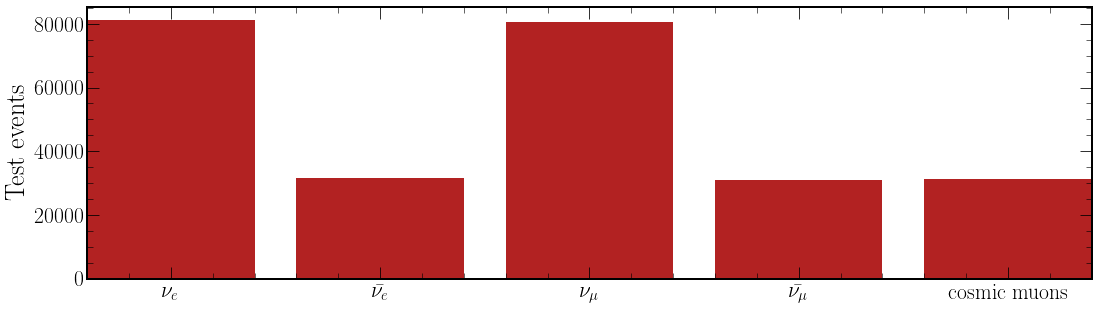

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
cats = np.arange(5)
axs.bar(
    cats, 
    [len(both_ev[(both_ev.t_nu_type == 0) & (both_ev.t_sign_type == 0) & (both_ev.t_cosmic_cat == 0)]), 
     len(both_ev[(both_ev.t_nu_type == 0) & (both_ev.t_sign_type == 1) & (both_ev.t_cosmic_cat == 0)]), 
     len(both_ev[(both_ev.t_nu_type == 1) & (both_ev.t_sign_type == 0) & (both_ev.t_cosmic_cat == 0)]), 
     len(both_ev[(both_ev.t_nu_type == 1) & (both_ev.t_sign_type == 1) & (both_ev.t_cosmic_cat == 0)]), 
     len(both_ev[both_ev.t_cosmic_cat == 1])],
    color="firebrick")
axs.set_xticks(cats)
axs.set_xticklabels(('$\\nu_{e}$', '$\\bar{\\nu_{e}}$', '$\\nu_{\mu}$', '$\\bar{\\nu_{\mu}}$', 'cosmic muons'))
axs.set_ylabel("Test events")
chipsnet.plotting.save(save_path + "nu_types")

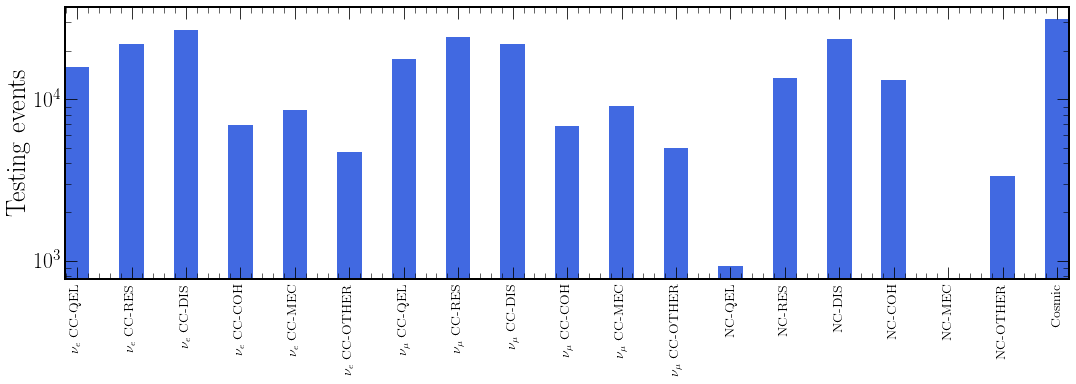

In [6]:
data_both = [
    len(both_ev[both_ev["t_nu_nc_cat"] == i])
    for i in range(len(chipsnet.data.MAP_NU_NC_COMB_CAT["labels"]))
]
cats = np.arange(len(chipsnet.data.MAP_NU_NC_COMB_CAT["labels"]))
width = 0.45

fig, axs = plt.subplots(1, 1, figsize=(18, 5), gridspec_kw={"hspace": 0.3})
axs.bar(cats, data_both, color="royalblue", width=width, label="training sample")
axs.set_xticks(cats)
axs.set_xticklabels(chipsnet.data.MAP_NU_NC_COMB_CAT["labels"], fontsize=14, rotation="vertical")
axs.set_ylabel("Testing events")
axs.set_yscale('log')
chipsnet.plotting.save(save_path + "training_sample")

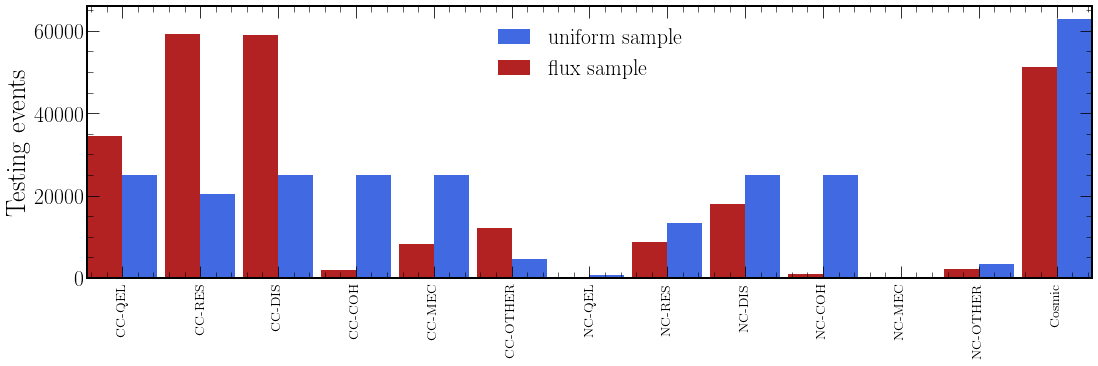

In [7]:
chipsnet.plotting.plot_cats(uniform_ev, flux_ev, chipsnet.data.MAP_INT_TYPE, save_path)

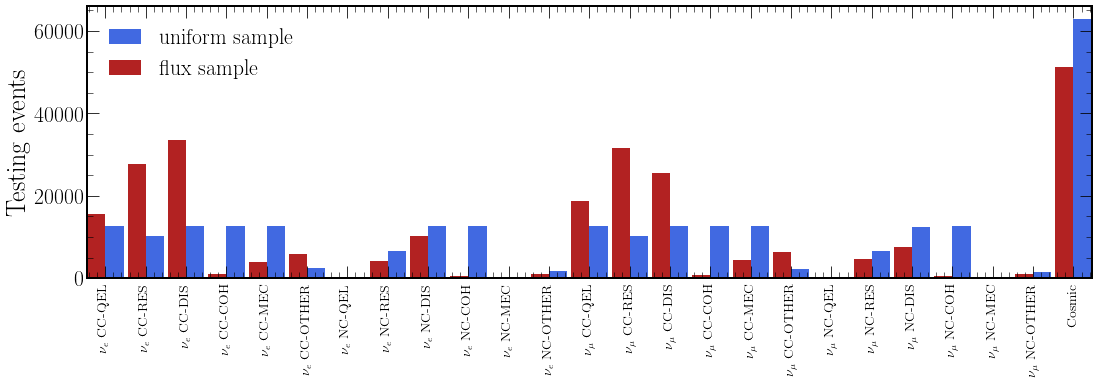

In [8]:
chipsnet.plotting.plot_cats(uniform_ev, flux_ev, chipsnet.data.MAP_ALL_CAT, save_path)

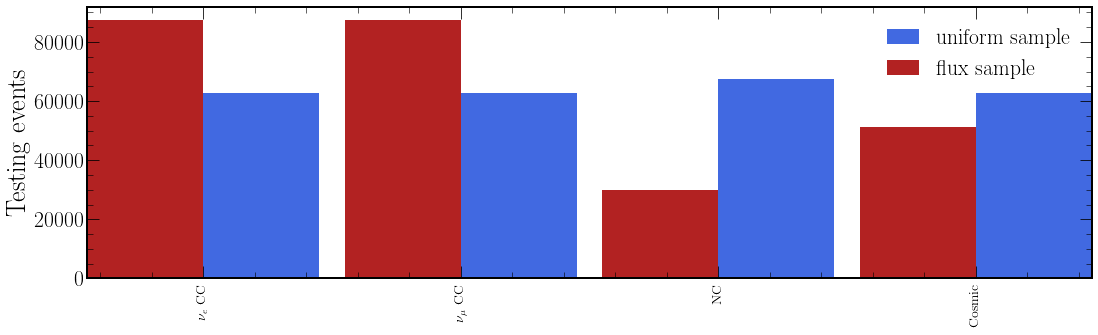

In [9]:
chipsnet.plotting.plot_cats(uniform_ev, flux_ev, chipsnet.data.MAP_FULL_COMB_CAT, save_path)

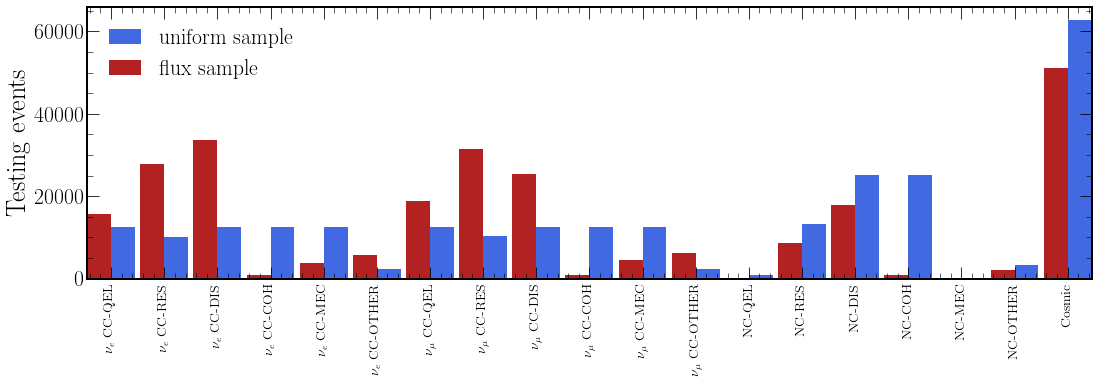

In [10]:
chipsnet.plotting.plot_cats(uniform_ev, flux_ev, chipsnet.data.MAP_NU_NC_COMB_CAT, save_path)

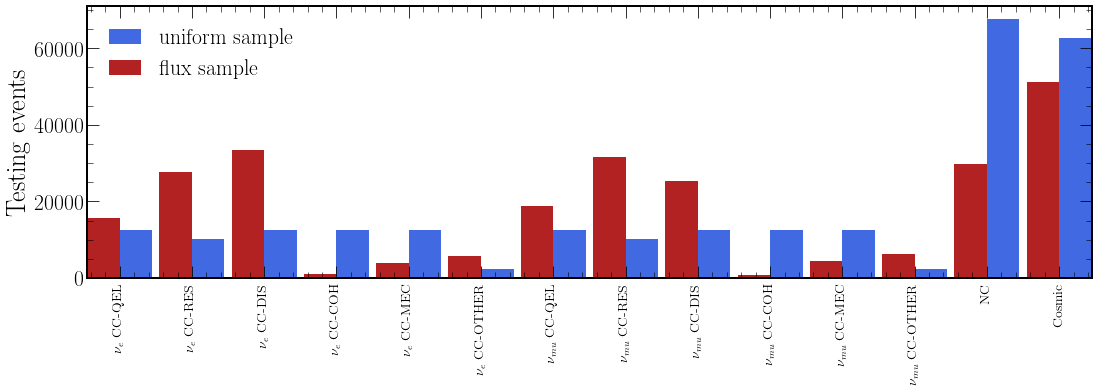

In [11]:
chipsnet.plotting.plot_cats(uniform_ev, flux_ev, chipsnet.data.MAP_NC_COMB_CAT, save_path)

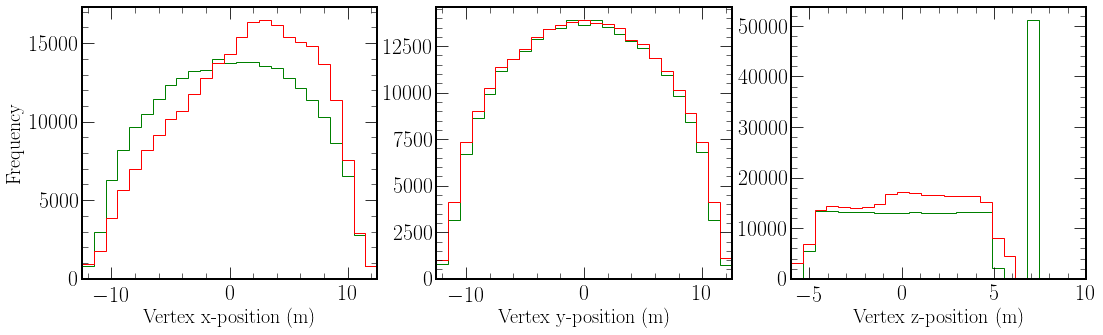

In [12]:
line_g = matplotlib.lines.Line2D([], [], c='green')
line_r = matplotlib.lines.Line2D([], [], c='red')

fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(flux_ev["t_vtx_x"]/100, range=(-12.5, 12.5), bins=25, color='green', histtype='step')
axs[0].hist(flux_ev["r_vtx_x"]*1250/100, range=(-12.5, 12.5), bins=25, color='red', histtype='step')
#axs[0].legend(loc="upper left", handles=[line_g, line_r], labels=["true", "reco"])
axs[0].set_xlabel('Vertex x-position (m)', fontsize=20)
axs[0].set_ylabel('Frequency', fontsize=20)

axs[1].hist(flux_ev["t_vtx_y"]/100, range=(-12.5, 12.5), bins=25, color='green', histtype='step')
axs[1].hist(flux_ev["r_vtx_y"]*1250/100, range=(-12.5, 12.5), bins=25, color='red', histtype='step')
#axs[1].legend(loc="upper left", handles=[line_g, line_r], labels=["true", "reco"])
axs[1].set_xlabel('Vertex y-position (m)', fontsize=20)

axs[2].hist(flux_ev["t_vtx_z"]/100, range=(-6, 10), bins=25, color='green', histtype='step')
axs[2].hist(flux_ev["r_vtx_z"]*600/100, range=(-6, 10), bins=25, color='red', histtype='step')
#axs[2].legend(loc="upper left", handles=[line_g, line_r], labels=["true", "reco"])
axs[2].set_xlabel('Vertex z-position (m)', fontsize=20)
chipsnet.plotting.save(save_path + "vtx_positions")

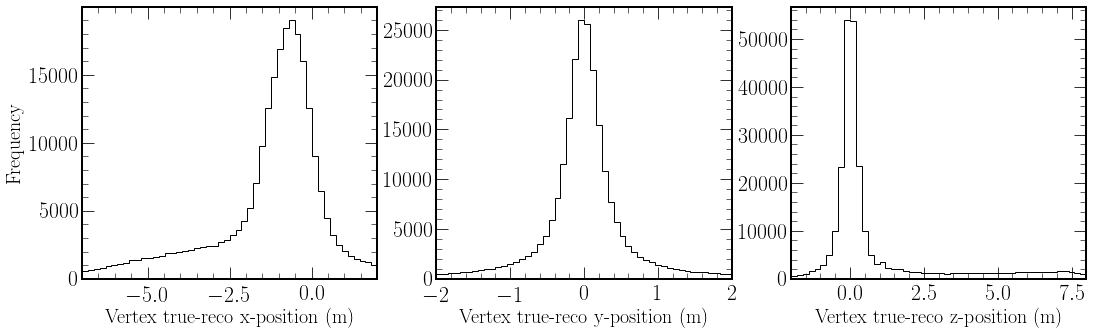

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(flux_ev["t_vtx_x"]/100-(flux_ev["r_vtx_x"]*1250/100), range=(-7, 2), bins=50, color='black', histtype='step')
axs[0].set_xlabel('Vertex true-reco x-position (m)', fontsize=20)
axs[0].set_ylabel('Frequency', fontsize=20)

axs[1].hist(flux_ev["t_vtx_y"]/100-(flux_ev["r_vtx_y"]*1250/100), range=(-2, 2), bins=50, color='black', histtype='step')
axs[1].set_xlabel('Vertex true-reco y-position (m)', fontsize=20)

axs[2].hist(flux_ev["t_vtx_z"]/100-(flux_ev["r_vtx_z"]*600/100), range=(-2, 8), bins=50, color='black', histtype='step')
axs[2].set_xlabel('Vertex true-reco z-position (m)', fontsize=20)
chipsnet.plotting.save(save_path + "true_reco_vtx")

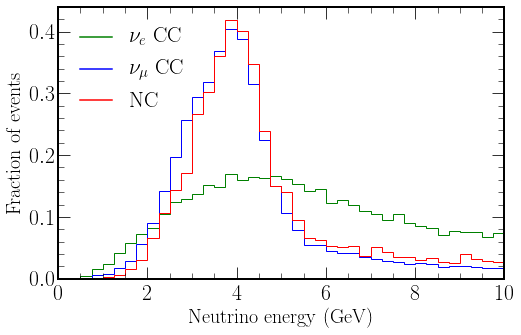

In [14]:
line_g = matplotlib.lines.Line2D([], [], c='green')
line_b = matplotlib.lines.Line2D([], [], c='blue')
line_r = matplotlib.lines.Line2D([], [], c='red')

fig, axs = plt.subplots(1, 1, figsize=(8, 5), gridspec_kw={'hspace': 0.3})
axs.hist(flux_ev[flux_ev["t_comb_cat"] == 0]["t_nu_energy"]/1000, weights=flux_ev[flux_ev["t_comb_cat"] == 0]["w"],
         range=(0, 10), bins=40, color='green', histtype='step', density=True)
axs.hist(flux_ev[flux_ev["t_comb_cat"] == 1]["t_nu_energy"]/1000, weights=flux_ev[flux_ev["t_comb_cat"] == 1]["w"],
         range=(0, 10), bins=40, color='blue', histtype='step', density=True)
axs.hist(flux_ev[flux_ev["t_comb_cat"] == 2]["t_nu_energy"]/1000, weights=flux_ev[flux_ev["t_comb_cat"] == 2]["w"],
         range=(0, 10), bins=40, color='red', histtype='step', density=True)
axs.legend(loc="upper left", handles=[line_g, line_b, line_r], labels=["$\\nu_{e}$ CC", "$\\nu_{\mu}$ CC", "NC"])
axs.set_xlabel('Neutrino energy (GeV)', fontsize=20)
axs.set_ylabel('Fraction of events', fontsize=20)
chipsnet.plotting.save(save_path + "nu_energies")

In [15]:
# Setup an images dictionary to hold example images
image_size = [64, 64]
images_dict = {"r_charge_map_origin": [], "r_charge_map_iso": [], "r_charge_map_vtx": [],
               "r_time_map_origin": [], "r_time_map_iso": [], "r_time_map_vtx": [], "r_hough_map_vtx": []}
               
# Load the images into the dictionary
nuel_file = uproot.open(nuel_map_file)
numu_file = uproot.open(numu_map_file)
cosmic_file = uproot.open(cosmic_map_file)
for image_name in images_dict.keys():
    images_dict[image_name].extend(nuel_file['reco'].array(image_name))
    images_dict[image_name].extend(numu_file['reco'].array(image_name))
    images_dict[image_name].extend(cosmic_file['reco'].array(image_name))

# Calculate fraction of hits in the endcaps
cap_total = 0
barrel_total = 0
for event in images_dict['r_charge_map_vtx']:
    sections = np.split(event, [18, 46], axis=0)
    cap_total += (sections[0].sum() + sections[2].sum())
    barrel_total += sections[1].sum()

# This is with cosmic events included
print("Fraction of deposited charge in endcaps = {}".format(cap_total/(cap_total+barrel_total)))

Fraction of deposited charge in endcaps = 0.4710996195164194


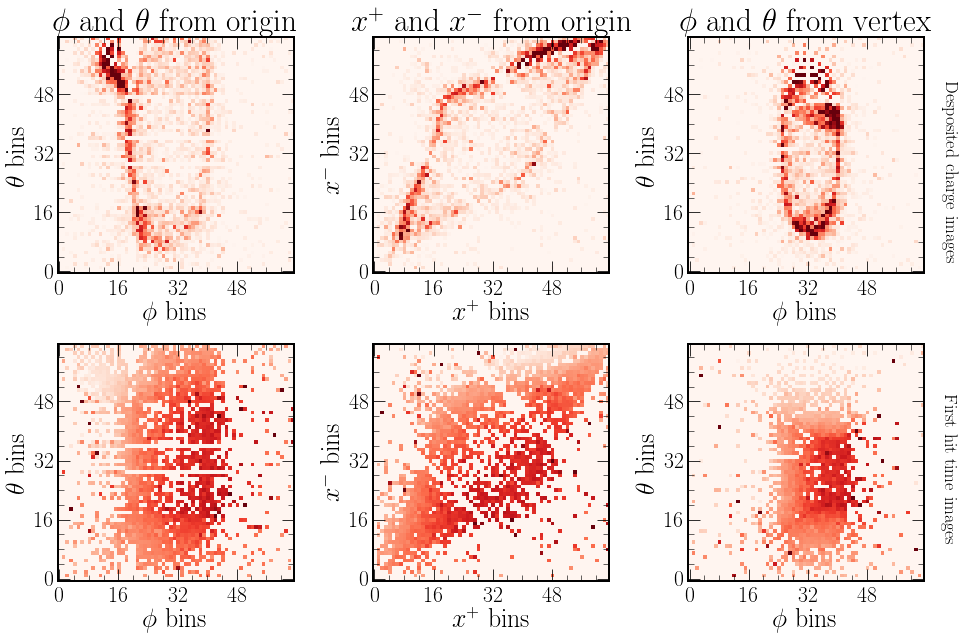

In [16]:
chipsnet.plotting.plot_hit_time(images_dict, 1, save_path)

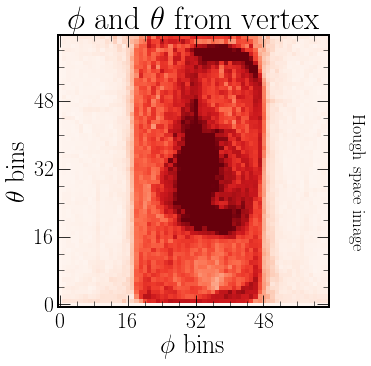

In [17]:
chipsnet.plotting.plot_hough(images_dict, 1, save_path)

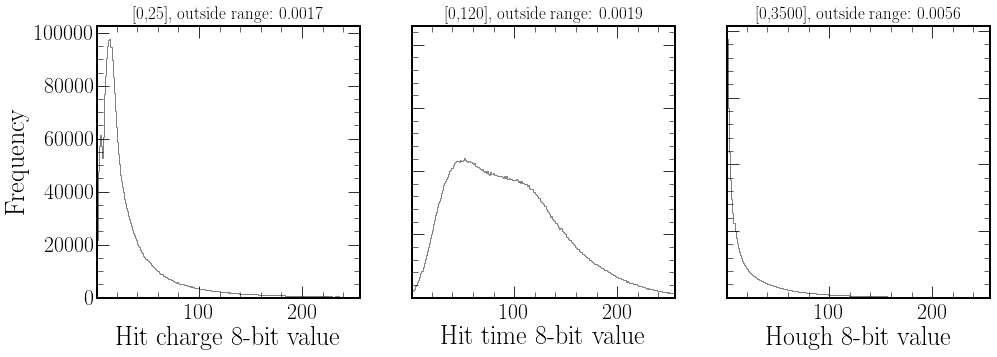

In [18]:
chipsnet.plotting.plot_8bit_range(images_dict, save_path=save_path)

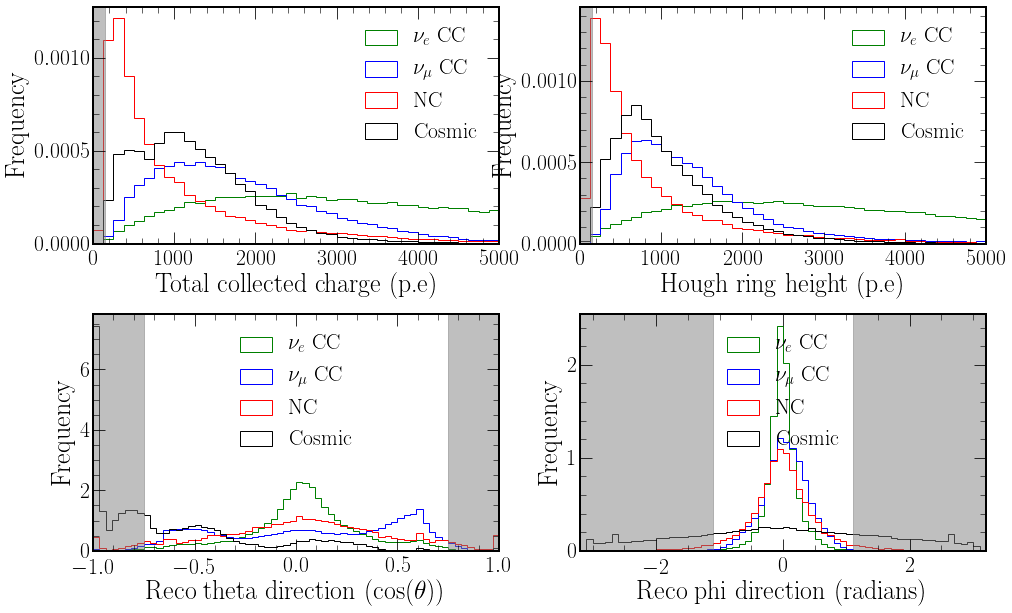

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10), gridspec_kw={'hspace': 0.3})
axs[0, 0].hist(flux_ev[flux_ev.t_comb_cat == 0]['r_total_digi_q'], color='green',
               histtype='step', range=(0, 5000), bins=40, density=True, label="$\\nu_{e}$ CC")
axs[0, 0].hist(flux_ev[flux_ev.t_comb_cat == 1]['r_total_digi_q'], color='blue', 
               histtype='step', range=(0, 5000), bins=40, density=True, label="$\\nu_{\mu}$ CC")
axs[0, 0].hist(flux_ev[flux_ev.t_comb_cat == 2]['r_total_digi_q'], color='red', 
               histtype='step', range=(0, 5000), bins=40, density=True, label="NC")
axs[0, 0].hist(flux_ev[flux_ev.t_comb_cat == 3]['r_total_digi_q'], color='black', 
               histtype='step', range=(0, 5000), bins=40, density=True, label="Cosmic")
axs[0, 0].set(xlabel='Total collected charge (p.e)', ylabel='Frequency')
axs[0, 0].axvspan(0, config.eval.cuts.q, alpha=0.5, color='grey')
axs[0, 0].legend()

axs[0, 1].hist(flux_ev[flux_ev.t_comb_cat == 0]['r_first_ring_height'], color='green',
               histtype='step', range=(0, 5000), bins=40, density=True, label="$\\nu_{e}$ CC")
axs[0, 1].hist(flux_ev[flux_ev.t_comb_cat == 1]['r_first_ring_height'], color='blue', 
               histtype='step', range=(0, 5000), bins=40, density=True, label="$\\nu_{\mu}$ CC")
axs[0, 1].hist(flux_ev[flux_ev.t_comb_cat == 2]['r_first_ring_height'], color='red', 
               histtype='step', range=(0, 5000), bins=40, density=True, label="NC")
axs[0, 1].hist(flux_ev[flux_ev.t_comb_cat == 3]['r_first_ring_height'], color='black', 
               histtype='step', range=(0, 5000), bins=40, density=True, label="Cosmic")
axs[0, 1].set(xlabel='Hough ring height (p.e)', ylabel='Frequency')
axs[0, 1].axvspan(0, config.eval.cuts.h, alpha=0.5, color='grey')
axs[0, 1].legend()

axs[1, 0].hist(flux_ev[flux_ev.t_comb_cat == 0]['r_dir_theta'], color='green',
               histtype='step', range=(-1, 1), bins=64, density=True, label="$\\nu_{e}$ CC")
axs[1, 0].hist(flux_ev[flux_ev.t_comb_cat == 1]['r_dir_theta'], color='blue', 
               histtype='step', range=(-1, 1), bins=64, density=True, label="$\\nu_{\mu}$ CC")
axs[1, 0].hist(flux_ev[flux_ev.t_comb_cat == 2]['r_dir_theta'], color='red', 
               histtype='step', range=(-1, 1), bins=64, density=True, label="NC")
axs[1, 0].hist(flux_ev[flux_ev.t_comb_cat == 3]['r_dir_theta'], color='black', 
               histtype='step', range=(-1, 1), bins=64, density=True, label="Cosmic")
axs[1, 0].set(xlabel='Reco theta direction (cos($\\theta$))', ylabel='Frequency')
axs[1, 0].axvspan(-1, -config.eval.cuts.theta, alpha=0.5, color='grey')
axs[1, 0].axvspan(config.eval.cuts.theta, 1, alpha=0.5, color='grey')
axs[1, 0].legend()

axs[1, 1].hist(flux_ev[flux_ev.t_comb_cat == 0]['r_dir_phi']*3.14159, color='green',
               histtype='step', range=(-3.2, 3.2), bins=64, density=True, label="$\\nu_{e}$ CC")
axs[1, 1].hist(flux_ev[flux_ev.t_comb_cat == 1]['r_dir_phi']*3.14159, color='blue', 
               histtype='step', range=(-3.2, 3.2), bins=64, density=True, label="$\\nu_{\mu}$ CC")
axs[1, 1].hist(flux_ev[flux_ev.t_comb_cat == 2]['r_dir_phi']*3.14159, color='red', 
               histtype='step', range=(-3.2, 3.2), bins=64, density=True, label="NC")
axs[1, 1].hist(flux_ev[flux_ev.t_comb_cat == 3]['r_dir_phi']*3.14159, color='black', 
               histtype='step', range=(-3.2, 3.2), bins=64, density=True, label="Cosmic")
axs[1, 1].set(xlabel='Reco phi direction (radians)', ylabel='Frequency')
axs[1, 1].axvspan(-3.2, -config.eval.cuts.phi*3.14159, alpha=0.5, color='grey')
axs[1, 1].axvspan(config.eval.cuts.phi*3.14159, 3.2, alpha=0.5, color='grey')
axs[1, 1].legend()
chipsnet.plotting.save(save_path + "simple_cuts")

In [20]:
# Tidy up
del both_ev, both_out
del flux_ev, flux_out
del uniform_ev, uniform_out
del images_dict

<a id='repr'></a>

## Which image representation is best? (repr)
* The theta/phi representation as viewed from the roughly reconstructed interaction vertex is clearly the best
* It does seem to do this by sacrificing a bit of purity for greater efficiency, but overall its still better.
* The fact that both origin view representations are similar, hints that the parameterisation is less important and where you view the interaction from is key.

In [21]:
v_ev, v_out = chipsnet.utils.process_ds(config, "v_ct_flux", ["repr_v_ct"])  # Vertex theta/phi repr
o_ev, o_out = chipsnet.utils.process_ds(config, "o_ct_flux", ["repr_o_ct"])  # Origin theta/phi repr
i_ev, i_out = chipsnet.utils.process_ds(config, "i_ct_flux", ["repr_i_ct"])  # Origin x+/x- repr

Processing v_ct_flux... found no image_2... took 279.59 seconds
Processing o_ct_flux... found no image_2... took 303.10 seconds
Processing i_ct_flux... found no image_2... took 284.47 seconds


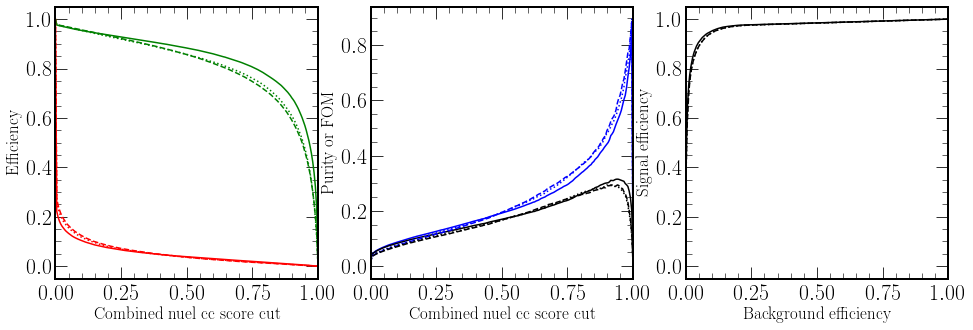

In [22]:
chipsnet.plotting.plot_curves([v_out[0], o_out[0], i_out[0]], save_path+"repr_curves")

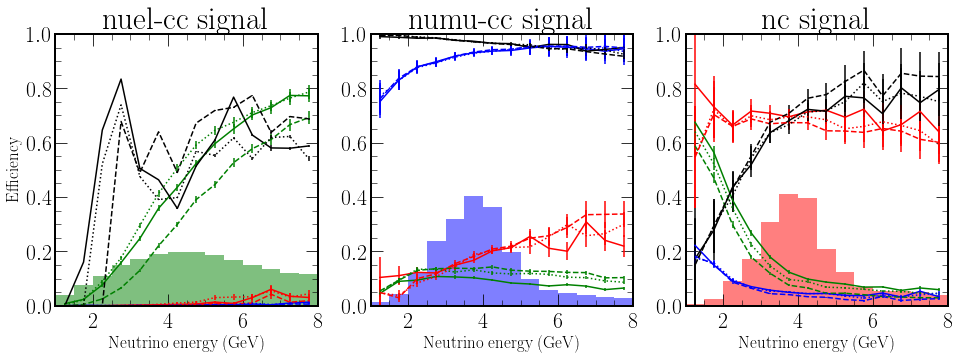

In [23]:
chipsnet.plotting.plot_e_hists([v_out[0], o_out[0], i_out[0]], v_ev, save_path+"repr_hists")

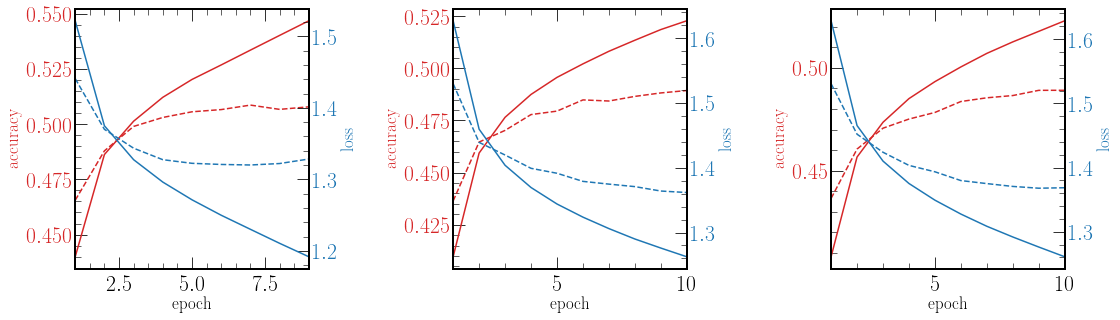

In [24]:
chipsnet.plotting.plot_history_comparison(config, ["repr_v_ct", "repr_o_ct", "repr_i_ct"], save_path+"repr_history")

In [25]:
chipsnet.utils.print_output_comparison([v_out[0], o_out[0], i_out[0]])

Max FOMs: 0.3150473219626743
Max FOM cuts: 0.9400000000000001
Sig eff AUC: 0.8425195385321643
Bkg eff AUC: 0.05090496727242544
Purity AUC: 0.23180880860463987
FOM AUC: 0.17714159304755067
ROC AUC: 0.97270872175191
              precision    recall  f1-score   support

           0       0.92      0.92      0.92    109642
           1       0.97      0.94      0.95    109080
           2       0.73      0.77      0.75     37278

    accuracy                           0.91    256000
   macro avg       0.87      0.88      0.87    256000
weighted avg       0.91      0.91      0.91    256000

              precision    recall  f1-score   support

           0       0.42      0.70      0.53     19655
           1       0.52      0.42      0.47     34681
           2       0.71      0.71      0.71     42129
           3       0.10      0.27      0.15      1202
           4       0.15      0.01      0.02      4775
           5       0.40      0.06      0.10      7200
           6       0.50   

In [26]:
# Tidy up
del v_ev, v_out
del o_ev, o_out
del i_ev, i_out

<a id='channel'></a>

## Which channel configuration is best? (channel)
* The differences are much smaller than you would expect given the extra info you would think the extra channels provide
* Overall having all three channels together does make a difference
* It also is much better to have the seperate stems for each channel rather than using a single 3 channel image

In [27]:
c_ev, c_out = chipsnet.utils.process_ds(config, "v_c_flux", ["repr_v_c"])  # Just charge channel
ct_ev, ct_out = chipsnet.utils.process_ds(config, "v_ct_flux", ["repr_v_ct"])  # Charge+time channels
cth_ev, cth_out = chipsnet.utils.process_ds(config,"v_cth_flux", ["repr_v_cth"])  # Charge+time+hough channels
cth_stacked_ev, cth_stacked_out = chipsnet.utils.process_ds(config,"v_cth_flux_stacked", ["repr_v_cth_stacked"])  # Charge+time+hough channels stacked

Processing v_c_flux... found no image_1... found no image_2... took 227.75 seconds
Processing v_ct_flux... found no image_2... took 245.79 seconds
Processing v_cth_flux... took 304.83 seconds
Processing v_cth_flux_stacked... found no image_1... found no image_2... took 292.95 seconds


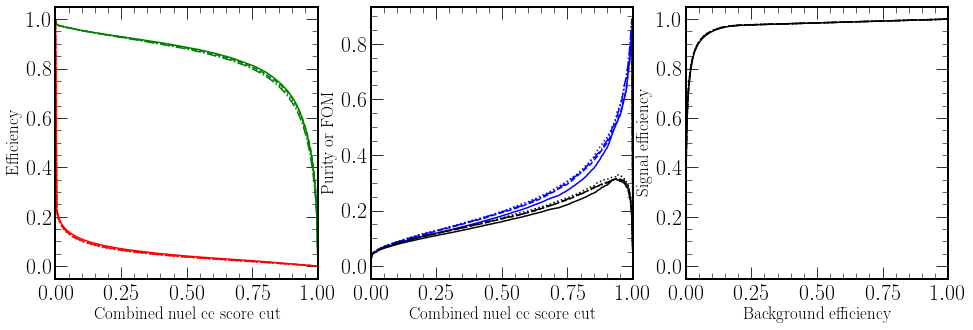

In [28]:
chipsnet.plotting.plot_curves([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], save_path+"channel_curves")

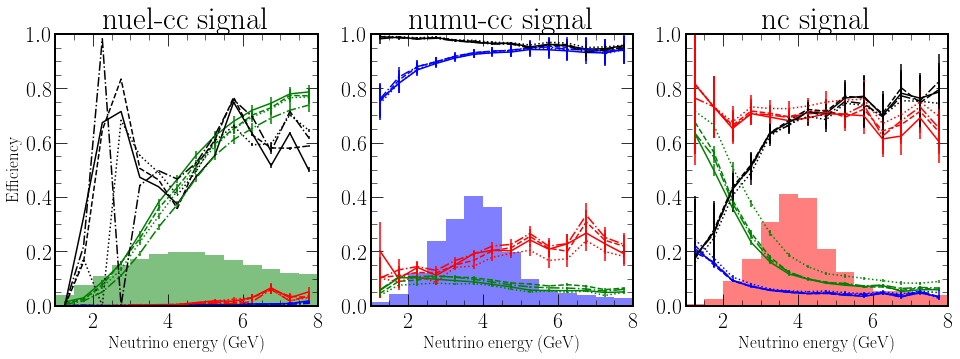

In [29]:
chipsnet.plotting.plot_e_hists([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], c_ev, save_path+"channel_hists")

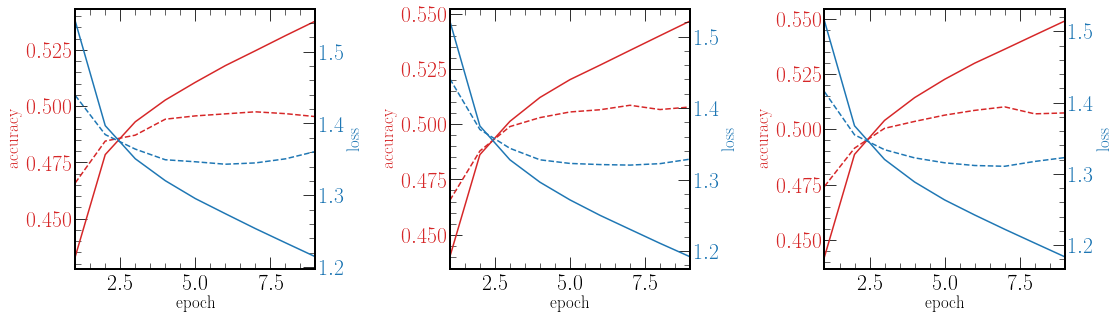

In [30]:
chipsnet.plotting.plot_history_comparison(config, ["repr_v_c", "repr_v_ct", "repr_v_cth"], save_path+"channel_history")

In [31]:
chipsnet.utils.print_output_comparison([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]])

Max FOMs: 0.3124600229896256
Max FOM cuts: 0.935
Sig eff AUC: 0.8447585515496729
Bkg eff AUC: 0.054419329309494266
Purity AUC: 0.22002379436411237
FOM AUC: 0.1676962924706601
ROC AUC: 0.9719244818039716
              precision    recall  f1-score   support

           0       0.91      0.93      0.92    109642
           1       0.97      0.93      0.95    109080
           2       0.73      0.76      0.74     37278

    accuracy                           0.91    256000
   macro avg       0.87      0.87      0.87    256000
weighted avg       0.91      0.91      0.91    256000

              precision    recall  f1-score   support

           0       0.41      0.70      0.51     19655
           1       0.51      0.39      0.44     34681
           2       0.70      0.70      0.70     42129
           3       0.10      0.29      0.14      1202
           4       0.15      0.03      0.04      4775
           5       0.37      0.05      0.09      7200
           6       0.50      0.82    

In [32]:
# Tidy up
del c_ev, c_out
del ct_ev, ct_out
del cth_ev, cth_out
del cth_stacked_ev, cth_stacked_out

<a id='sample'></a>

## Which training sample is best? (sample)
* The training sample you use and its relative number of events for each category makes a significant difference to performance.
* As expected training on a beam flux distribution is much better than a uniform sample.
* Bolstering the underepresented categories in the beam flux however leads to much better performance in seperating CC and NC types.

In [33]:
events, outputs = chipsnet.utils.process_ds(
    config, 
    "flux", 
    ["sample_both", "sample_flux", "sample_uniform"],
    ["t_nu_nc_cat", "t_nu_nc_cat", "t_nu_nc_cat"]
)

Processing flux... took 841.38 seconds


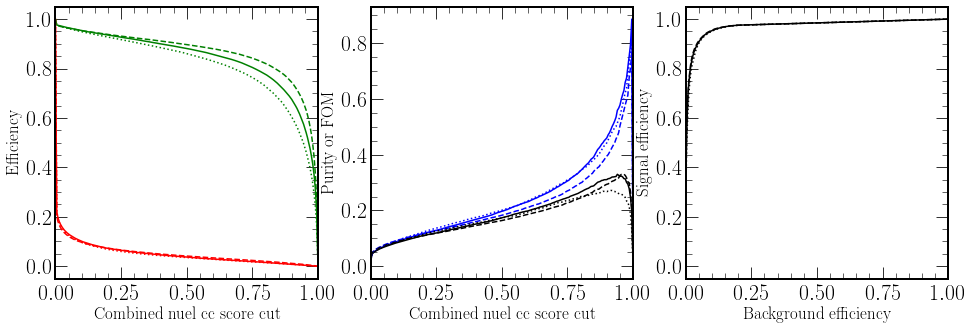

In [34]:
chipsnet.plotting.plot_curves([outputs[0], outputs[1], outputs[2]], save_path+"sample_curves")

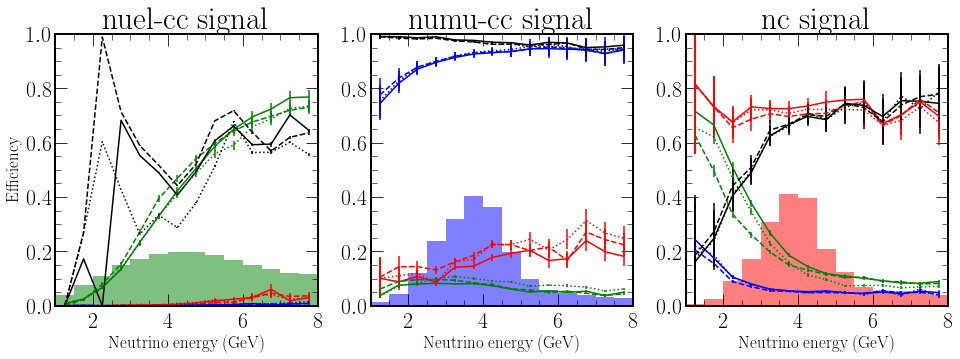

In [35]:
chipsnet.plotting.plot_e_hists([outputs[0], outputs[1], outputs[2]], events, save_path+"sample_hists")

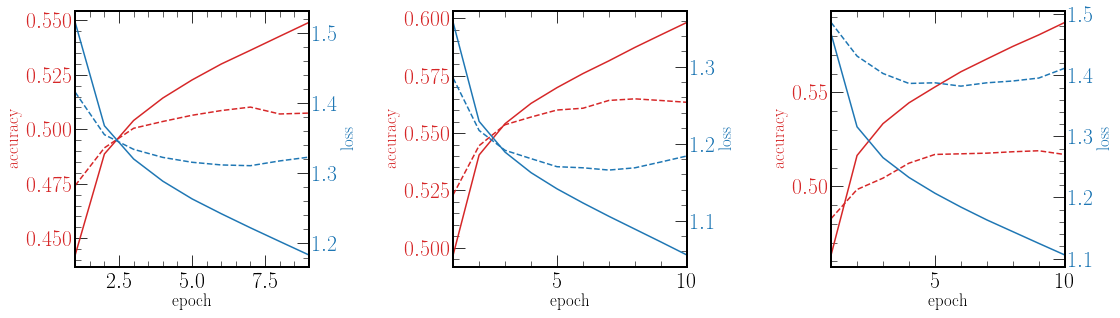

In [36]:
chipsnet.plotting.plot_history_comparison(config, ["sample_both", "sample_flux", "sample_uniform"], save_path+"sample_history")

In [37]:
chipsnet.utils.print_output_comparison([outputs[0], outputs[1], outputs[2]])

Max FOMs: 0.3297784742878769
Max FOM cuts: 0.9400000000000001
Sig eff AUC: 0.8401028145817253
Bkg eff AUC: 0.049484184057506014
Purity AUC: 0.23992870141287315
FOM AUC: 0.1820334659585141
ROC AUC: 0.9730825061765749
              precision    recall  f1-score   support

           0       0.92      0.92      0.92    109642
           1       0.97      0.94      0.95    109080
           2       0.72      0.77      0.75     37278

    accuracy                           0.91    256000
   macro avg       0.87      0.88      0.87    256000
weighted avg       0.91      0.91      0.91    256000

              precision    recall  f1-score   support

           0       0.42      0.70      0.53     19655
           1       0.52      0.44      0.48     34681
           2       0.72      0.70      0.71     42129
           3       0.11      0.27      0.16      1202
           4       0.19      0.01      0.03      4775
           5       0.41      0.06      0.10      7200
           6       0.50 

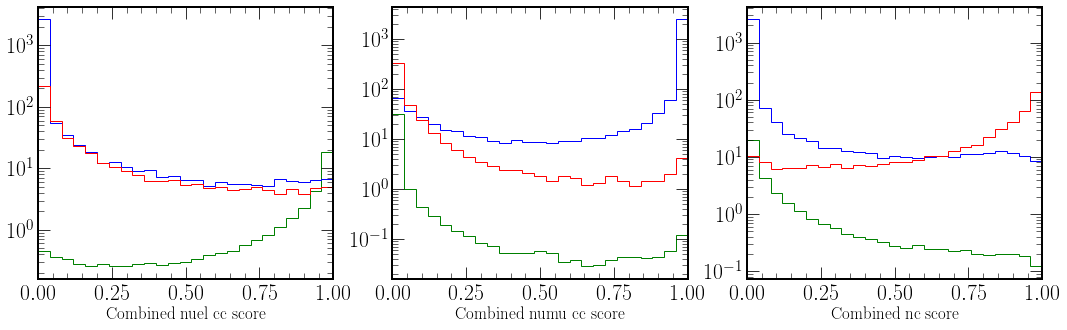

In [38]:
chipsnet.plotting.plot_combined_values(events, "sample_both_", save_path+"sample_both_values")

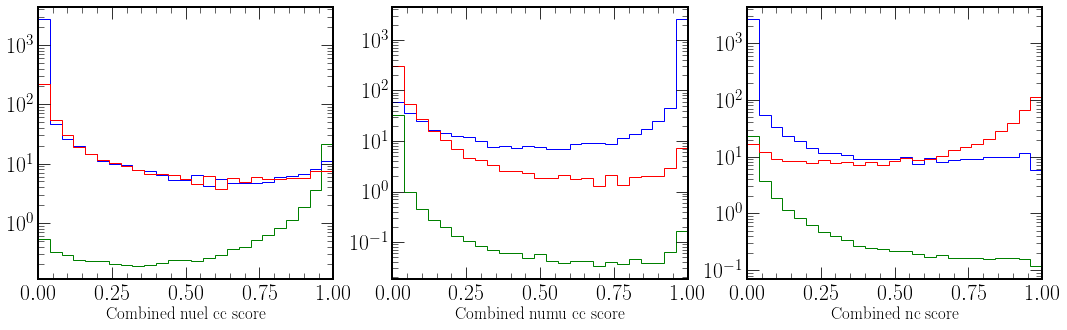

In [39]:
chipsnet.plotting.plot_combined_values(events, "sample_flux_", save_path+"sample_flux_values")

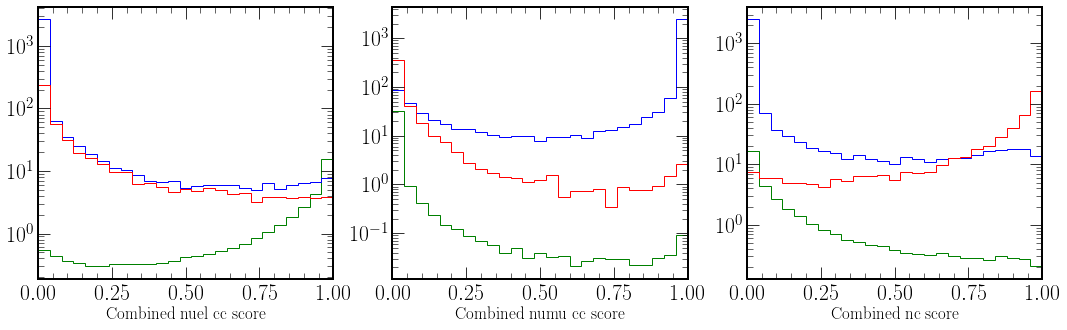

In [40]:
chipsnet.plotting.plot_combined_values(events, "sample_uniform_", save_path+"sample_uniform_values")

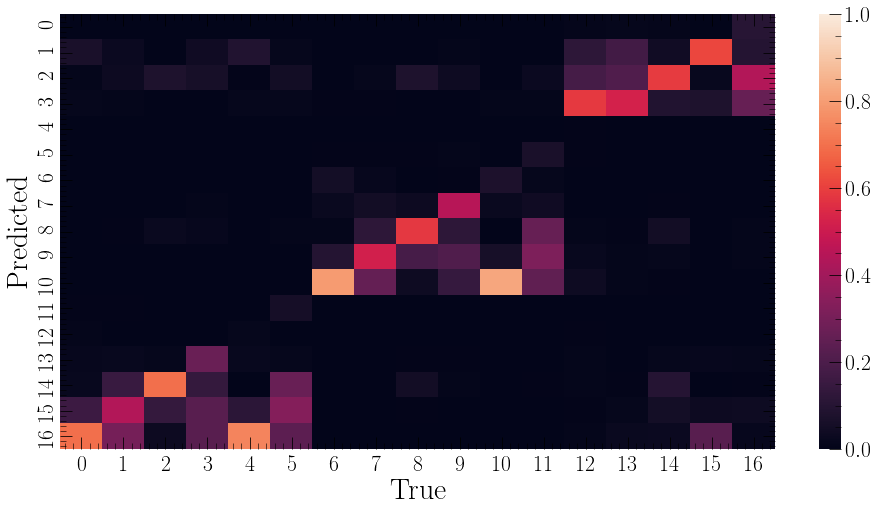

In [41]:
plt.figure(figsize=(16,8))
sns.heatmap(outputs[0]["all_matrices"], annot=False, vmin=0.0, vmax=1.0)
plt.xlabel('True', fontsize = 30)
plt.ylabel('Predicted', fontsize = 30)
plt.show()

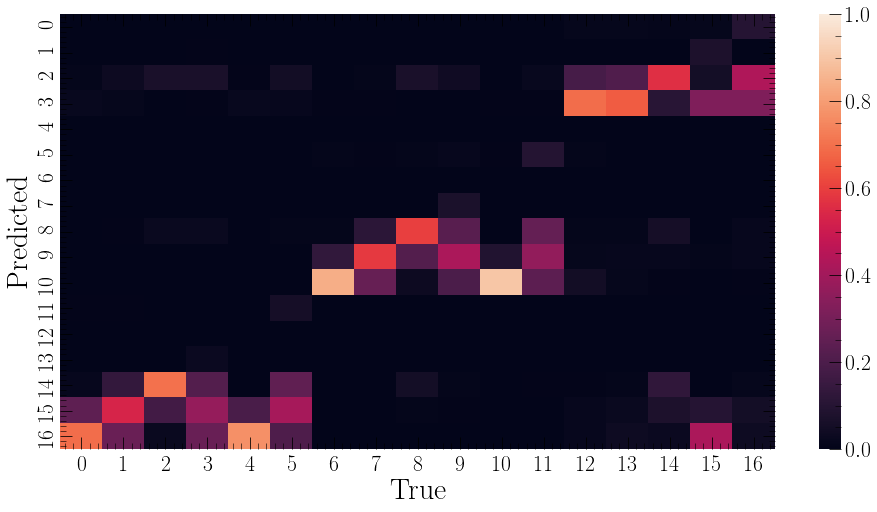

In [42]:
plt.figure(figsize=(16,8))
sns.heatmap(outputs[1]["all_matrices"], annot=False, vmin=0.0, vmax=1.0)
plt.xlabel('True', fontsize = 30)
plt.ylabel('Predicted', fontsize = 30)
plt.show()

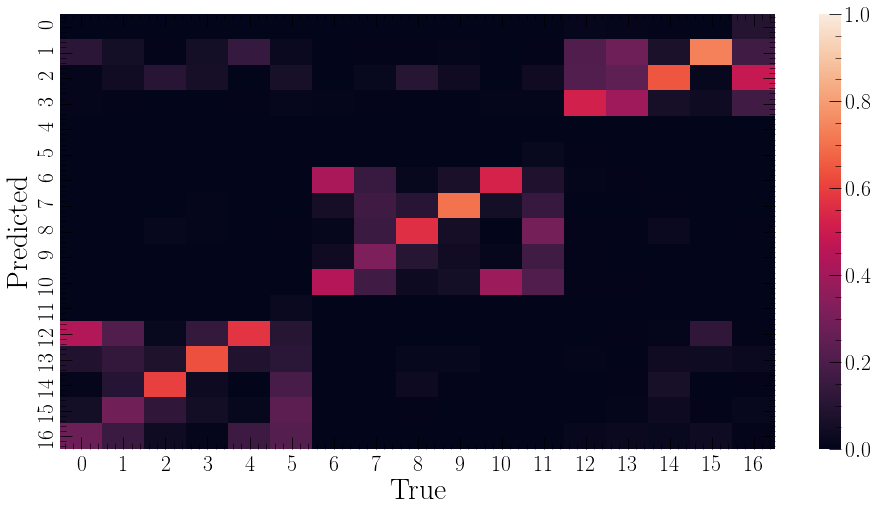

In [43]:
plt.figure(figsize=(16,8))
sns.heatmap(outputs[2]["all_matrices"], annot=False, vmin=0.0, vmax=1.0)
plt.xlabel('True', fontsize = 30)
plt.ylabel('Predicted', fontsize = 30)
plt.show()

In [44]:
# Tidy up
del events, outputs

<a id='cat'></a>

## Which categorisation is best? (cat)
* It looks like the split learner using ["t_comb_cat", "t_cc_type", "t_nc_type"] is the best
* Still need to look at how well it splits apart to cc and nc types for full analysis
* A close second is then "t_nu_nc_cat" maybe this is still reasonable to use to simplify other studies

In [45]:
events, outputs = chipsnet.utils.process_ds(
    config, 
    "flux", 
    ["cat_t_final_cat", "cat_t_all_cat", "cat_t_comb_cat", "cat_t_nu_nc_cat", "cat_t_nc_cat", "cat_split", "cat_split_learn"], 
    ["t_final_cat", "t_all_cat", "t_comb_cat", "t_nu_nc_cat", "t_nc_cat", "t_comb_cat", "t_comb_cat"]
)

Processing flux... took 1731.49 seconds


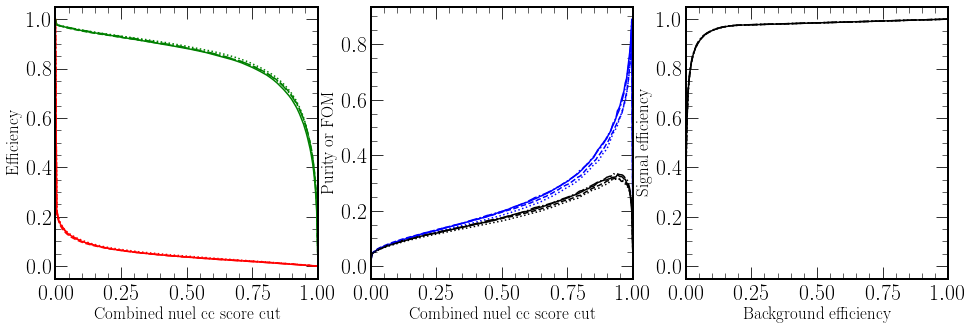

In [46]:
chipsnet.plotting.plot_curves([outputs[3], outputs[0], outputs[1], outputs[5]], save_path+"cat_curves")

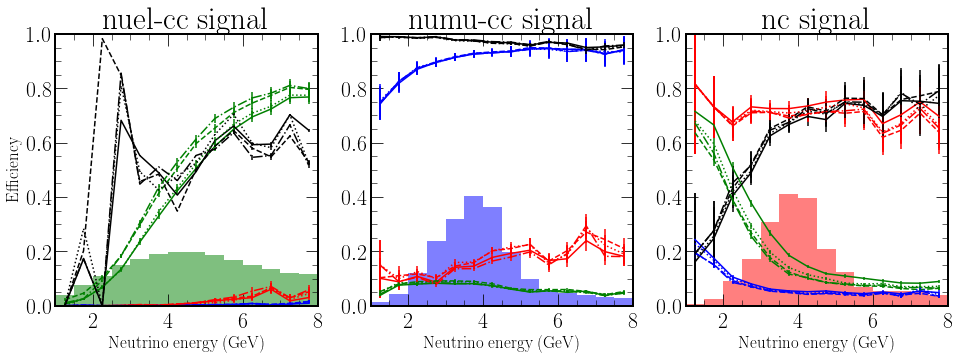

In [47]:
chipsnet.plotting.plot_e_hists([outputs[3], outputs[0], outputs[1], outputs[5]], events, save_path+"cat_hists")

In [48]:
chipsnet.utils.print_output_comparison([outputs[0], outputs[1], outputs[2], outputs[3], outputs[4], outputs[5], outputs[6]])

Max FOMs: 0.316868957537652
Max FOM cuts: 0.93
Sig eff AUC: 0.8446212152928575
Bkg eff AUC: 0.04925344573086548
Purity AUC: 0.23217873266616834
FOM AUC: 0.17932663340648242
ROC AUC: 0.972889293469173
              precision    recall  f1-score   support

           0       0.92      0.92      0.92    109642
           1       0.97      0.94      0.95    109080
           2       0.72      0.78      0.75     37278

    accuracy                           0.91    256000
   macro avg       0.87      0.88      0.87    256000
weighted avg       0.91      0.91      0.91    256000

              precision    recall  f1-score   support

           0       0.52      0.80      0.63     24430
           1       0.53      0.39      0.45     34681
           2       0.71      0.70      0.71     42129
           3       0.11      0.24      0.15      1202
           4       0.40      0.06      0.10      7200
           5       0.62      0.89      0.73     29027
           6       0.63      0.51      0

In [49]:
# Tidy up
del events, outputs

<a id='cosmic'></a>

## Does vertex help cosmic classifier? (cosmic)
* Can't really come to a full conclusion without knowing if the events that pass will contaminate our signal
* Looks like adding the vertex position and time, makes the average values better, by the number of events that get accepted gets worse.

In [50]:
events, outputs = chipsnet.utils.process_ds(
    config, 
    "flux_cosmic",
    ["cosmic", "cosmic_vtx", "cosmic_vtx_learn"],
    model_cats=["t_cosmic_cat", "t_cosmic_cat", "t_cosmic_cat"],
    verbose=True
)

Processing flux_cosmic... 

Nuel:   51826, weight: 0.00075, actual: 38.88
Anuel:  51601, weight: 0.00005, actual: 2.53
Numu:   50912, weight: 0.06586, actual: 3353.22
Anumu:  50461, weight: 0.00145, actual: 73.36
Cosmic: 51200, weight: 23.646, actual: 1210697.86
count    2.048000e+05
mean     1.019741e-03
std      2.589205e-02
min      0.000000e+00
25%      1.249049e-28
50%      1.299581e-24
75%      1.243421e-19
max      1.000000e+00
Name: cosmic_pred_t_cosmic_cat, dtype: float64
count    51200.000000
mean         0.998295
std          0.031009
min          0.000030
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: cosmic_pred_t_cosmic_cat, dtype: float64
count    2.048000e+05
mean     3.502097e-04
std      1.657636e-02
min      8.083752e-13
25%      1.725783e-08
50%      2.169172e-07
75%      1.640821e-06
max      9.999950e-01
Name: cosmic_vtx_pred_t_cosmic_cat, dtype: float64
count    51200.000000
mean         0.998467
std          0.03363

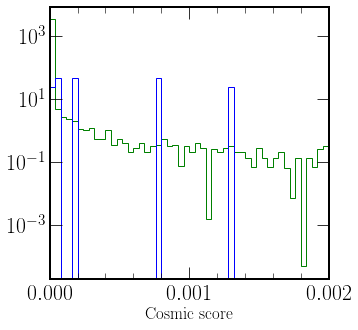

In [51]:
bins = 50
hist_range = (0, 0.002)
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.hist(
    events[events["t_cosmic_cat"] == 0]["cosmic_pred_t_cosmic_cat"],
    weights=events[events["t_cosmic_cat"] == 0]["w"],
    range=hist_range,
    bins=bins,
    color="green",
    histtype="step",
)
axs.hist(
    events[events["t_cosmic_cat"] == 1]["cosmic_pred_t_cosmic_cat"],
    weights=events[events["t_cosmic_cat"] == 1]["w"],
    range=hist_range,
    bins=bins,
    color="blue",
    histtype="step",
)
axs.set_xlabel("Cosmic score", fontsize=17)
axs.set_yscale("log")
plt.show()

In [52]:
# Tidy up
del events, outputs

<a id='beam'></a>

## Does primary count help beam classifier? (beam)
* Yes it does help, not a huge effect but it definitely add something, which makes sense
* The "learned" version of the multitask weights seems to work best.
* Still need to combine with the correct category type to see if that has a different effect.

In [53]:
events, outputs = chipsnet.utils.process_ds(
    config, 
    "flux", 
    ["beam", "beam_primaries", "beam_primaries_learn"],
    ["t_nu_nc_cat", "t_nu_nc_cat", "t_nu_nc_cat"]
)

Processing flux... took 894.91 seconds


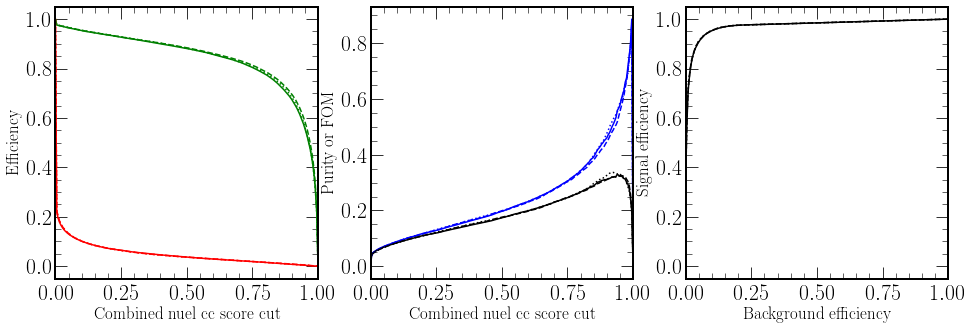

In [54]:
chipsnet.plotting.plot_curves([outputs[0], outputs[1], outputs[2]], save_path+"beam_curves")

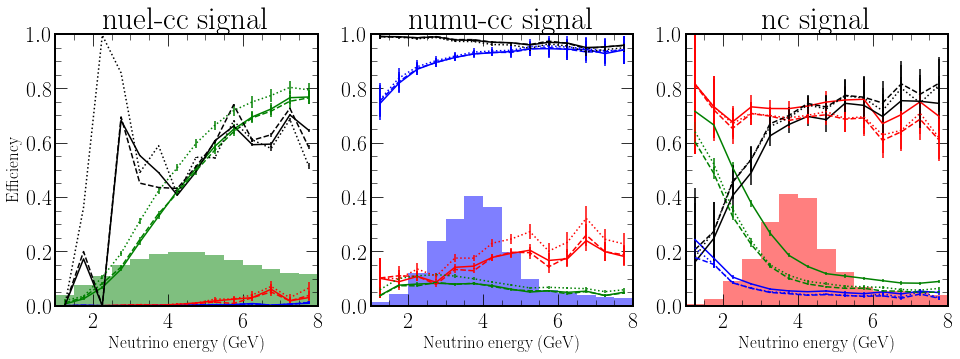

In [55]:
chipsnet.plotting.plot_e_hists([outputs[0], outputs[1], outputs[2]], events, save_path+"beam_hists")

In [56]:
chipsnet.utils.print_output_comparison([outputs[0], outputs[1], outputs[2]])

Max FOMs: 0.3297784742878769
Max FOM cuts: 0.9400000000000001
Sig eff AUC: 0.8401028145817253
Bkg eff AUC: 0.049484184057506014
Purity AUC: 0.23992870141287315
FOM AUC: 0.1820334659585141
ROC AUC: 0.9730825061765749
              precision    recall  f1-score   support

           0       0.92      0.92      0.92    109642
           1       0.97      0.94      0.95    109080
           2       0.72      0.77      0.75     37278

    accuracy                           0.91    256000
   macro avg       0.87      0.88      0.87    256000
weighted avg       0.91      0.91      0.91    256000

              precision    recall  f1-score   support

           0       0.42      0.70      0.53     19655
           1       0.52      0.44      0.48     34681
           2       0.72      0.70      0.71     42129
           3       0.11      0.27      0.16      1202
           4       0.19      0.01      0.03      4775
           5       0.41      0.06      0.10      7200
           6       0.50 

In [57]:
# Tidy up
del events, outputs

<a id='energy'></a>

## Does lepton energy help neutrino energy estimation? (energy)
* There doesn't seem to be a noticable difference when both are trained together
* This has only been testing on nuel cc, it may be different for numu cc
* As its negligable we will train together using the learned approach as that seems best

In [4]:
events = chipsnet.utils.predict_energies(config, "flux", ["energy", "lepton", "energy_lepton", "energy_lepton_learn"])

Processing flux... took 166.25 seconds


/mnt/storage/jtingey/chips-net/chipsnet/utils.py:1351: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = subset[(events[par] <= (cut + bin_size))]


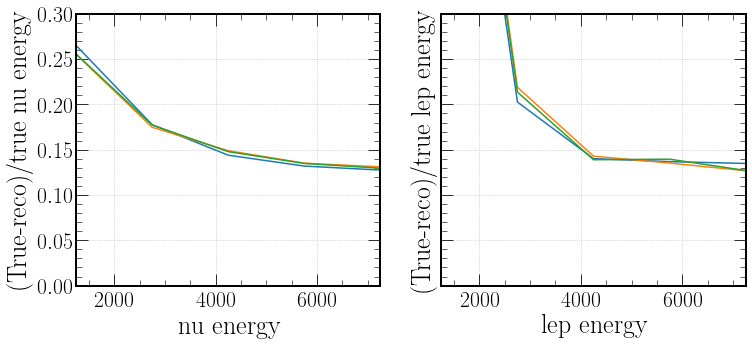

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.2})
e_list, std_list = chipsnet.utils.frac_e_vs_par(events[events["t_comb_cat"] == 0], fit_name="energy_frac_nu_energy")
axs[0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(events[events["t_comb_cat"] == 0], fit_name="energy_lepton_frac_nu_energy")
axs[0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(events[events["t_comb_cat"] == 0], fit_name="energy_lepton_learn_frac_nu_energy")
axs[0].plot(e_list, std_list)
axs[0].label_outer()
axs[0].set(ylabel=r"(True-reco)/true nu energy", xlabel=r"nu energy")
axs[0].set_ylim(0, 0.3)
axs[0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(events[events["t_comb_cat"] == 0], par="t_lep_energy", fit_name="lepton_frac_lep_energy")
axs[1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(events[events["t_comb_cat"] == 0], par="t_lep_energy", fit_name="energy_lepton_frac_lep_energy")
axs[1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(events[events["t_comb_cat"] == 0], par="t_lep_energy", fit_name="energy_lepton_learn_frac_lep_energy")
axs[1].plot(e_list, std_list)
axs[1].label_outer()
axs[1].set(ylabel=r"(True-reco)/true lep energy", xlabel=r"lep energy")
axs[1].set_ylim(0, 0.3)
axs[1].grid()
plt.show()

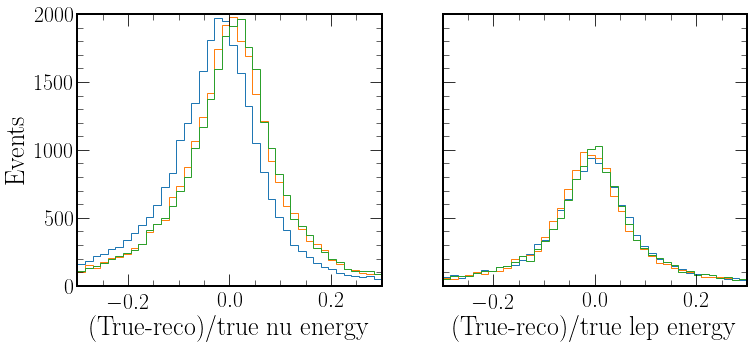

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.2})
axs[0].hist(events[events["t_comb_cat"] == 0]['energy_frac_nu_energy'], range=(-0.3, 0.3), bins=40, histtype='step')
axs[0].hist(events[events["t_comb_cat"] == 0]['energy_lepton_frac_nu_energy'], range=(-0.3, 0.3), bins=40, histtype='step')
axs[0].hist(events[events["t_comb_cat"] == 0]['energy_lepton_learn_frac_nu_energy'], range=(-0.3, 0.3), bins=40, histtype='step')
axs[0].set(xlabel=r"(True-reco)/true nu energy", ylabel=r"Events")
axs[0].label_outer()
axs[0].set_ylim(0, 2000)
axs[1].hist(events[events["t_comb_cat"] == 0]['lepton_frac_lep_energy'], range=(-0.3, 0.3), bins=40, histtype='step')
axs[1].hist(events[events["t_comb_cat"] == 0]['energy_lepton_frac_lep_energy'], range=(-0.3, 0.3), bins=40, histtype='step')
axs[1].hist(events[events["t_comb_cat"] == 0]['energy_lepton_learn_frac_lep_energy'], range=(-0.3, 0.3), bins=40, histtype='step')
axs[1].set(xlabel=r"(True-reco)/true lep energy", ylabel=r"Events")
axs[1].label_outer()
axs[1].set_ylim(0, 2000)
plt.show()

In [48]:
print(events[events["t_comb_cat"] == 0]['energy_frac_nu_energy'].describe())
print(events[events["t_comb_cat"] == 0]['energy_lepton_frac_nu_energy'].describe())
print(events[events["t_comb_cat"] == 0]['energy_lepton_learn_frac_nu_energy'].describe())

count    27304.000000
mean        -0.036111
std          0.142229
min         -0.816519
25%         -0.096186
50%         -0.026812
75%          0.029778
max          2.068038
Name: energy_frac_nu_energy, dtype: float64
count    27304.000000
mean        -0.005018
std          0.145216
min         -0.839270
25%         -0.066490
50%          0.000284
75%          0.059829
max          1.528692
Name: energy_lepton_frac_nu_energy, dtype: float64
count    27304.000000
mean        -0.002198
std          0.143922
min         -0.799790
25%         -0.063062
50%          0.004874
75%          0.062679
max          1.586972
Name: energy_lepton_learn_frac_nu_energy, dtype: float64


In [49]:
# Tidy up
del events

<a id='energy_samples'></a>

## Different sample energy estimation (energy_samples)
* The vertex location for muon events greatly effects the energy reconstruction performance due to not being fully contained.
* Can reach 5% energy resolution of QEL and MEC electrons.
* Lots of the DIS/RES are not having their true lepton energy found which is odd.

In [50]:
# All the different interaction type samples and associated models
nuel_cccoh_ev = chipsnet.utils.predict_energies(config, "nuel_cccoh", ["nuel_cccoh_energy"])
nuel_ccdis_ev = chipsnet.utils.predict_energies(config, "nuel_ccdis", ["nuel_ccdis_energy"])
nuel_ccqel_ev = chipsnet.utils.predict_energies(config, "nuel_ccqel", ["nuel_ccqel_energy"])
nuel_ccres_ev = chipsnet.utils.predict_energies(config, "nuel_ccres", ["nuel_ccres_energy"])
nuel_ccmec_ev = chipsnet.utils.predict_energies(config, "nuel_ccmec", ["nuel_ccmec_energy"])
nuel_ccqelmec_ev = chipsnet.utils.predict_energies(config, "nuel_ccqelmec", ["nuel_ccqelmec_energy"])
numu_cccoh_ev = chipsnet.utils.predict_energies(config, "numu_cccoh", ["numu_cccoh_energy"])
numu_ccdis_ev = chipsnet.utils.predict_energies(config, "numu_ccdis", ["numu_ccdis_energy"])
numu_ccqel_ev = chipsnet.utils.predict_energies(config, "numu_ccqel", ["numu_ccqel_energy"])
numu_ccres_ev = chipsnet.utils.predict_energies(config, "numu_ccres", ["numu_ccres_energy"])
numu_ccmec_ev = chipsnet.utils.predict_energies(config, "numu_ccmec", ["numu_ccmec_energy"])
numu_ccqelmec_ev = chipsnet.utils.predict_energies(config, "numu_ccqelmec", ["numu_ccqelmec_energy"])
flux_ev = chipsnet.utils.predict_energies(config, "flux", ["nuel_cc_energy", "numu_cc_energy", "nc_energy"])

Processing nuel_cccoh... took 18.50 seconds
Processing nuel_ccdis... took 17.15 seconds
Processing nuel_ccqel... took 17.37 seconds
Processing nuel_ccres... took 16.97 seconds
Processing nuel_ccmec... took 18.05 seconds
Processing nuel_ccqelmec... took 34.64 seconds
Processing numu_cccoh... took 19.64 seconds
Processing numu_ccdis... took 20.30 seconds
Processing numu_ccqel... took 19.28 seconds
Processing numu_ccres... took 18.26 seconds
Processing numu_ccmec... took 19.71 seconds
Processing numu_ccqelmec... took 34.12 seconds
Processing flux... took 137.17 seconds


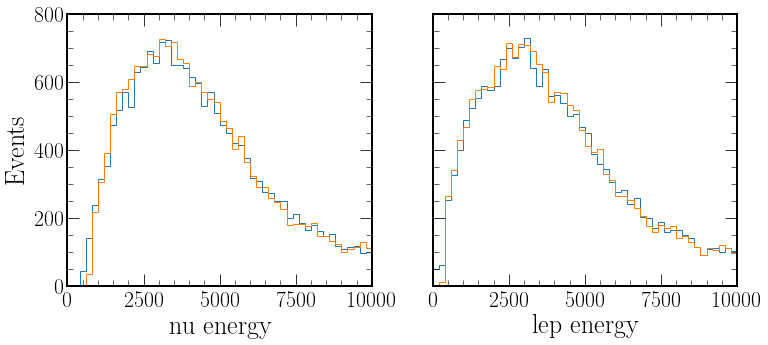

In [94]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.2})
axs[0].hist(nuel_ccqel_ev['t_nu_energy'], range=(0, 10000), bins=50, histtype='step')
axs[0].hist(nuel_ccqel_ev['nuel_ccqel_energy_pred_t_nu_energy'], range=(0, 10000), bins=50, histtype='step')
axs[0].set(xlabel=r"nu energy", ylabel=r"Events")
axs[0].label_outer()
axs[0].set_ylim(0, 800)
axs[1].hist(nuel_ccqel_ev['t_lep_energy'], range=(0, 10000), bins=50, histtype='step')
axs[1].hist(nuel_ccqel_ev['nuel_ccqel_energy_pred_t_lep_energy'], range=(0, 10000), bins=50, histtype='step')
axs[1].set(xlabel=r"lep energy", ylabel=r"Events")
axs[1].label_outer()
axs[1].set_ylim(0, 800)
plt.show()

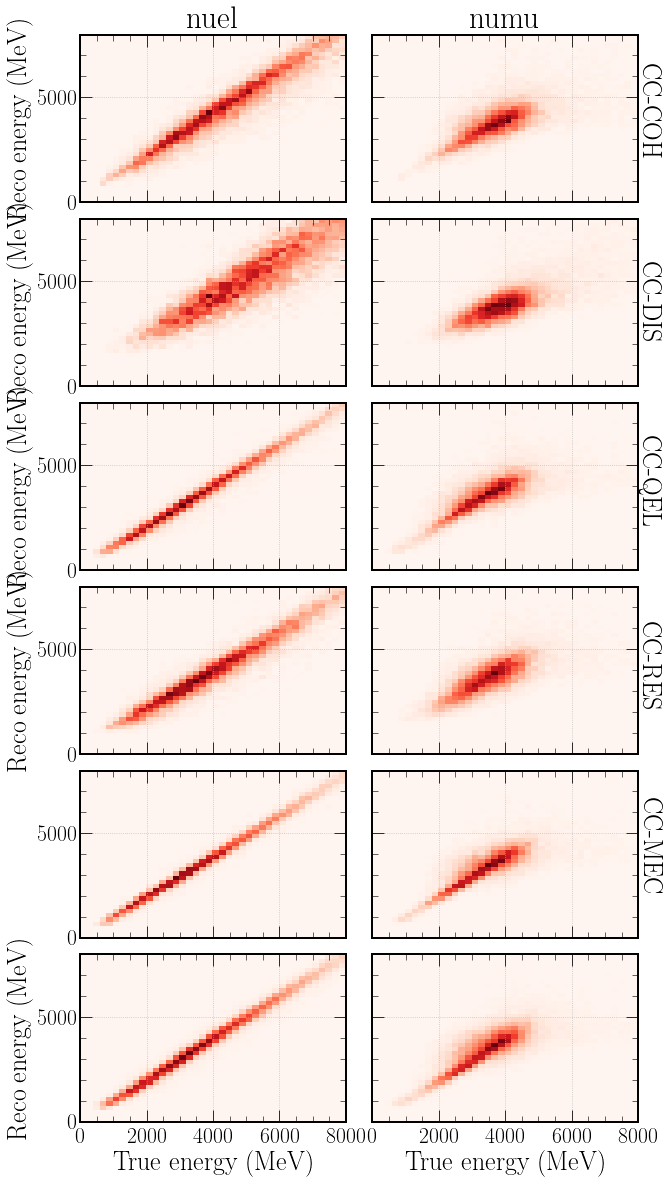

In [57]:
e_range = [[0, 8000], [0, 8000]]
e_bins = [40, 40]
fig, axs = plt.subplots(6, 2, figsize=(10, 20), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
axs[0, 0].hist2d(nuel_cccoh_ev["t_nu_energy"], nuel_cccoh_ev["nuel_cccoh_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[0, 0].grid()
axs[0, 0].label_outer()
axs[0, 0].set(ylabel=r"Reco energy (MeV)")
axs[0, 0].set_title(r"nuel")
axs[1, 0].hist2d(nuel_ccdis_ev["t_nu_energy"], nuel_ccdis_ev["nuel_ccdis_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[1, 0].grid()
axs[1, 0].label_outer()
axs[1, 0].set(ylabel=r"Reco energy (MeV)")
axs[2, 0].hist2d(nuel_ccqel_ev["t_nu_energy"], nuel_ccqel_ev["nuel_ccqel_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[2, 0].grid()
axs[2, 0].label_outer()
axs[2, 0].set(ylabel=r"Reco energy (MeV)")
axs[3, 0].hist2d(nuel_ccres_ev["t_nu_energy"], nuel_ccres_ev["nuel_ccres_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[3, 0].grid()
axs[3, 0].label_outer()
axs[3, 0].set(ylabel=r"Reco energy (MeV)")
axs[4, 0].hist2d(nuel_ccmec_ev["t_nu_energy"], nuel_ccmec_ev["nuel_ccmec_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[4, 0].grid()
axs[4, 0].label_outer()
axs[5, 0].hist2d(nuel_ccqelmec_ev["t_nu_energy"], nuel_ccqelmec_ev["nuel_ccqelmec_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[5, 0].grid()
axs[5, 0].label_outer()
axs[5, 0].set(xlabel=r"True energy (MeV)", ylabel=r"Reco energy (MeV)")
axs[5, 0].set(xlabel=r"True energy (MeV)", ylabel=r"Reco energy (MeV)")
axs[0, 1].hist2d(numu_cccoh_ev["t_nu_energy"], numu_cccoh_ev["numu_cccoh_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[0, 1].grid()
axs[0, 1].label_outer()
axs[0, 1].set_title(r"numu")
axs[0, 1].text(8000, 2250, "CC-COH", rotation=-90)
axs[1, 1].hist2d(numu_ccdis_ev["t_nu_energy"], numu_ccdis_ev["numu_ccdis_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[1, 1].grid()
axs[1, 1].label_outer()
axs[1, 1].text(8000, 2250, "CC-DIS", rotation=-90)
axs[2, 1].hist2d(numu_ccqel_ev["t_nu_energy"], numu_ccqel_ev["numu_ccqel_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[2, 1].grid()
axs[2, 1].label_outer()
axs[2, 1].text(8000, 2250, "CC-QEL", rotation=-90)
axs[3, 1].hist2d(numu_ccres_ev["t_nu_energy"], numu_ccres_ev["numu_ccres_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[3, 1].grid()
axs[3, 1].label_outer()
axs[3, 1].text(8000, 2250, "CC-RES", rotation=-90)
axs[4, 1].hist2d(numu_ccmec_ev["t_nu_energy"], numu_ccmec_ev["numu_ccmec_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[4, 1].grid()
axs[4, 1].label_outer()
axs[4, 1].text(8000, 2250, "CC-MEC", rotation=-90)
axs[5, 1].hist2d(numu_ccqelmec_ev["t_nu_energy"], numu_ccqelmec_ev["numu_ccqelmec_energy_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[5, 1].grid()
axs[5, 1].label_outer()
axs[5, 1].set(xlabel=r"True energy (MeV)")
axs[5, 1].text(8000, 2250, "CC-QELMEC", rotation=-90)
chipsnet.plotting.save(save_path + "true_vs_reco_energy_cc")

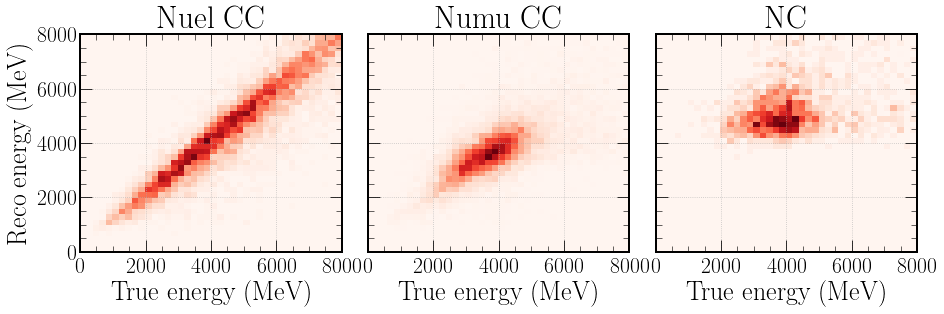

In [53]:
e_range = [[0, 8000], [0, 8000]]
e_bins = [40, 40]
fig, axs = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
axs[0].hist2d(flux_ev[flux_ev["t_comb_cat"] == 0]["t_nu_energy"], flux_ev[flux_ev["t_comb_cat"] == 0]["nuel_cc_energy_pred_t_nu_energy"],
              range=e_range, bins=e_bins, weights=flux_ev[flux_ev["t_comb_cat"] == 0]["w"], cmap="Reds")
axs[0].grid()
axs[0].label_outer()
axs[0].set(xlabel=r"True energy (MeV)", ylabel=r"Reco energy (MeV)")
axs[0].set_title(r"Nuel CC")
axs[1].hist2d(flux_ev[flux_ev["t_comb_cat"] == 1]["t_nu_energy"], flux_ev[flux_ev["t_comb_cat"] == 1]["numu_cc_energy_pred_t_nu_energy"],
              range=e_range, bins=e_bins, weights=flux_ev[flux_ev["t_comb_cat"] == 1]["w"], cmap="Reds")
axs[1].grid()
axs[1].label_outer()
axs[1].set(xlabel=r"True energy (MeV)")
axs[1].set_title(r"Numu CC")
axs[2].hist2d(flux_ev[flux_ev["t_comb_cat"] == 2]["t_nu_energy"], flux_ev[flux_ev["t_comb_cat"] == 2]["nc_energy_pred_t_nu_energy"],
              range=e_range, bins=e_bins, weights=flux_ev[flux_ev["t_comb_cat"] == 2]["w"], cmap="Reds")
axs[2].grid()
axs[2].label_outer()
axs[2].set(xlabel=r"True energy (MeV)")
axs[2].set_title(r"NC")
chipsnet.plotting.save(save_path + "true_vs_reco_energy_comb")

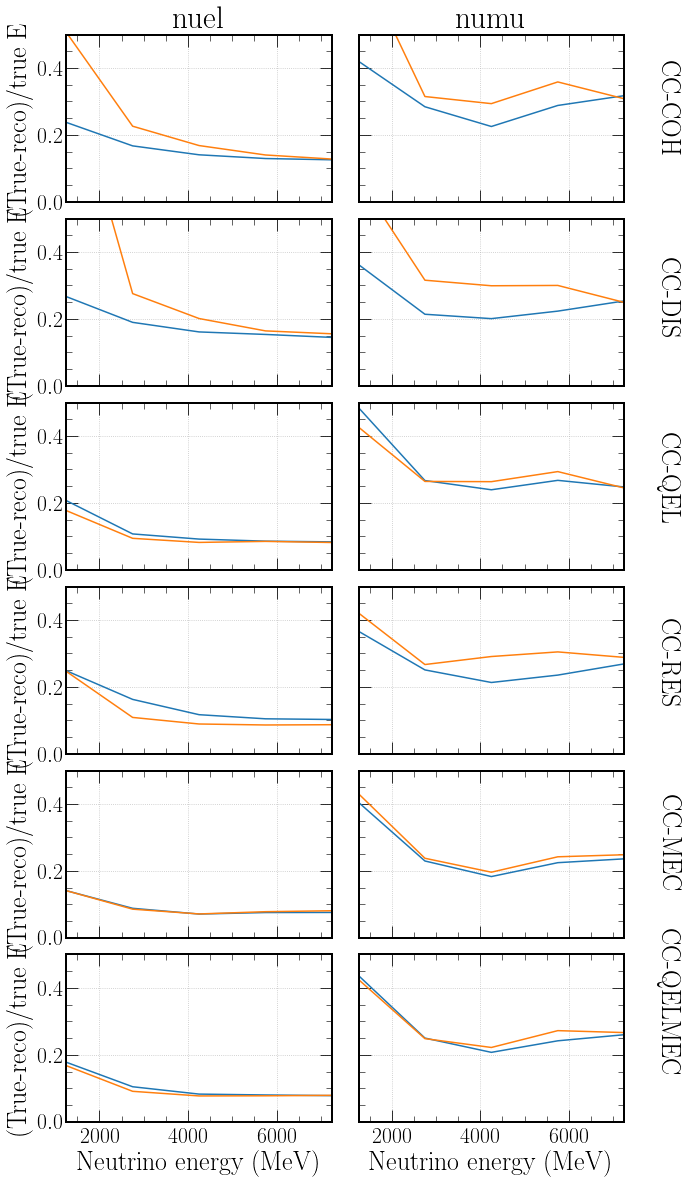

In [63]:
fig, axs = plt.subplots(6, 2, figsize=(10, 20), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_cccoh_ev, fit_name="nuel_cccoh_energy_frac_nu_energy")
axs[0, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_cccoh_ev, par="t_lep_energy", fit_name="nuel_cccoh_energy_frac_lep_energy")
axs[0, 0].plot(e_list, std_list)
axs[0, 0].label_outer()
axs[0, 0].set(ylabel=r"(True-reco)/true E")
axs[0, 0].set_title(r"nuel")
axs[0, 0].set_ylim(0, 0.5)
axs[0, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccdis_ev, fit_name="nuel_ccdis_energy_frac_nu_energy")
axs[1, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccdis_ev, par="t_lep_energy", fit_name="nuel_ccdis_energy_frac_lep_energy")
axs[1, 0].plot(e_list, std_list)
axs[1, 0].label_outer()
axs[1, 0].set(ylabel=r"(True-reco)/true E")
axs[1, 0].set_ylim(0, 0.5)
axs[1, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccqel_ev, fit_name="nuel_ccqel_energy_frac_nu_energy")
axs[2, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccqel_ev, par="t_lep_energy", fit_name="nuel_ccqel_energy_frac_lep_energy")
axs[2, 0].plot(e_list, std_list)
axs[2, 0].label_outer()
axs[2, 0].set(ylabel=r"(True-reco)/true E")
axs[2, 0].set_ylim(0, 0.5)
axs[2, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccres_ev, fit_name="nuel_ccres_energy_frac_nu_energy")
axs[3, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccres_ev, par="t_lep_energy", fit_name="nuel_ccres_energy_frac_lep_energy")
axs[3, 0].plot(e_list, std_list)
axs[3, 0].label_outer()
axs[3, 0].set(ylabel=r"(True-reco)/true E")
axs[3, 0].set_ylim(0, 0.5)
axs[3, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccmec_ev, fit_name="nuel_ccmec_energy_frac_nu_energy")
axs[4, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccmec_ev, par="t_lep_energy", fit_name="nuel_ccmec_energy_frac_lep_energy")
axs[4, 0].plot(e_list, std_list)
axs[4, 0].label_outer()
axs[4, 0].set(ylabel=r"(True-reco)/true E")
axs[4, 0].set_ylim(0, 0.5)
axs[4, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccqelmec_ev, fit_name="nuel_ccqelmec_energy_frac_nu_energy")
axs[5, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccqelmec_ev, par="t_lep_energy", fit_name="nuel_ccqelmec_energy_frac_lep_energy")
axs[5, 0].plot(e_list, std_list)
axs[5, 0].label_outer()
axs[5, 0].set(xlabel=r"Neutrino energy (MeV)", ylabel=r"(True-reco)/true E")
axs[5, 0].set_ylim(0, 0.5)
axs[5, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_cccoh_ev, fit_name="numu_cccoh_energy_frac_nu_energy")
axs[0, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_cccoh_ev, par="t_lep_energy", fit_name="numu_cccoh_energy_frac_lep_energy")
axs[0, 1].plot(e_list, std_list)
axs[0, 1].label_outer()
axs[0, 1].set_title(r"numu")
axs[0, 1].text(8000, 0.15, "CC-COH", rotation=-90)
axs[0, 1].set_ylim(0, 0.5)
axs[0, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccdis_ev, fit_name="numu_ccdis_energy_frac_nu_energy")
axs[1, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccdis_ev, par="t_lep_energy", fit_name="numu_ccdis_energy_frac_lep_energy")
axs[1, 1].plot(e_list, std_list)
axs[1, 1].label_outer()
axs[1, 1].text(8000, 0.15, "CC-DIS", rotation=-90)
axs[1, 1].set_ylim(0, 0.5)
axs[1, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccqel_ev, fit_name="numu_ccqel_energy_frac_nu_energy")
axs[2, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccqel_ev, par="t_lep_energy", fit_name="numu_ccqel_energy_frac_lep_energy")
axs[2, 1].plot(e_list, std_list)
axs[2, 1].label_outer()
axs[2, 1].text(8000, 0.15, "CC-QEL", rotation=-90)
axs[2, 1].set_ylim(0, 0.5)
axs[2, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccres_ev, fit_name="numu_ccres_energy_frac_nu_energy")
axs[3, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccres_ev, par="t_lep_energy", fit_name="numu_ccres_energy_frac_lep_energy")
axs[3, 1].plot(e_list, std_list)
axs[3, 1].label_outer()
axs[3, 1].text(8000, 0.15, "CC-RES", rotation=-90)
axs[3, 1].set_ylim(0, 0.5)
axs[3, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccmec_ev, fit_name="numu_ccmec_energy_frac_nu_energy")
axs[4, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccmec_ev, par="t_lep_energy", fit_name="numu_ccmec_energy_frac_lep_energy")
axs[4, 1].plot(e_list, std_list)
axs[4, 1].label_outer()
axs[4, 1].text(8000, 0.15, "CC-MEC", rotation=-90)
axs[4, 1].set_ylim(0, 0.5)
axs[4, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccqelmec_ev, fit_name="numu_ccqelmec_energy_frac_nu_energy")
axs[5, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccqelmec_ev, par="t_lep_energy", fit_name="numu_ccqelmec_energy_frac_lep_energy")
axs[5, 1].plot(e_list, std_list)
axs[5, 1].label_outer()
axs[5, 1].set(xlabel=r"Neutrino energy (MeV)")
axs[5, 1].text(8000, 0.15, "CC-QELMEC", rotation=-90)
axs[5, 1].set_ylim(0, 0.5)
axs[5, 1].grid()
chipsnet.plotting.save(save_path + "true_vs_frac_energy")

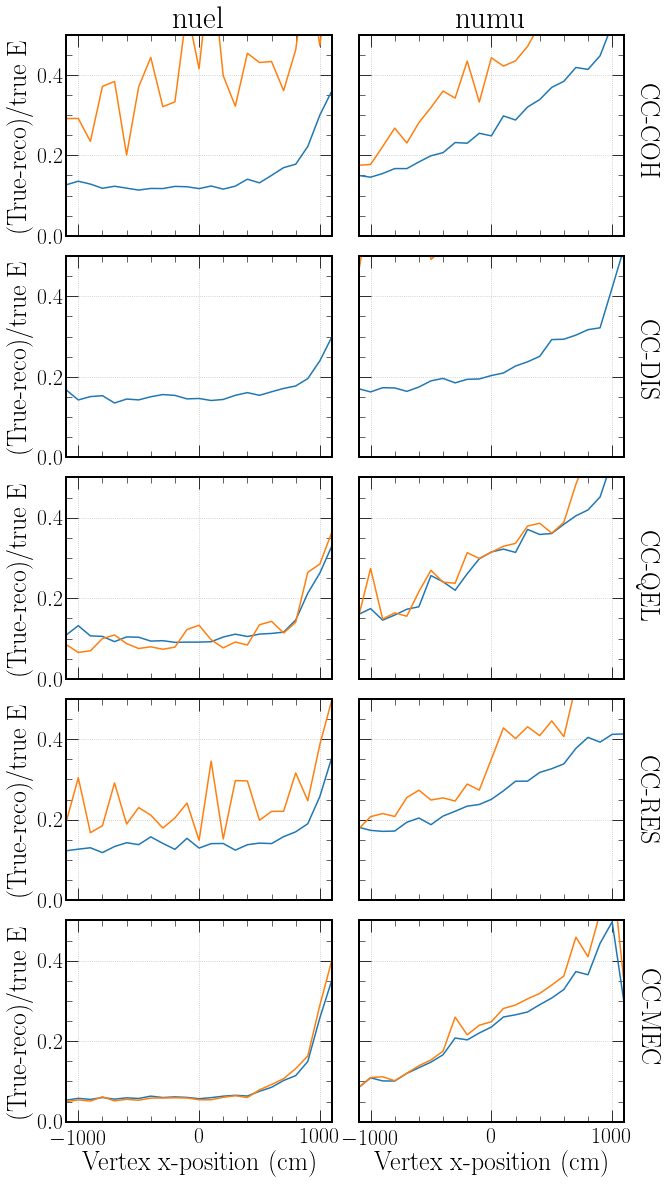

In [97]:
fig, axs = plt.subplots(5, 2, figsize=(10, 20), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_cccoh_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_cccoh_energy_frac_nu_energy")
axs[0, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_cccoh_ev[(nuel_cccoh_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_cccoh_energy_frac_lep_energy")
axs[0, 0].plot(e_list, std_list)
axs[0, 0].label_outer()
axs[0, 0].set(ylabel=r"(True-reco)/true E")
axs[0, 0].set_title(r"nuel")
axs[0, 0].set_ylim(0, 0.5)
axs[0, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccdis_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccdis_energy_frac_nu_energy")
axs[1, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccdis_ev[(nuel_ccdis_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccdis_energy_frac_lep_energy")
axs[1, 0].plot(e_list, std_list)
axs[1, 0].label_outer()
axs[1, 0].set(ylabel=r"(True-reco)/true E")
axs[1, 0].set_ylim(0, 0.5)
axs[1, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccqel_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccqel_energy_frac_nu_energy")
axs[2, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccqel_ev[(nuel_ccqel_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccqel_energy_frac_lep_energy")
axs[2, 0].plot(e_list, std_list)
axs[2, 0].label_outer()
axs[2, 0].set(ylabel=r"(True-reco)/true E")
axs[2, 0].set_ylim(0, 0.5)
axs[2, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccres_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccres_energy_frac_nu_energy")
axs[3, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccres_ev[(nuel_ccres_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccres_energy_frac_lep_energy")
axs[3, 0].plot(e_list, std_list)
axs[3, 0].label_outer()
axs[3, 0].set(ylabel=r"(True-reco)/true E")
axs[3, 0].set_ylim(0, 0.5)
axs[3, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccmec_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccmec_energy_frac_nu_energy")
axs[4, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccmec_ev[(nuel_ccmec_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccmec_energy_frac_lep_energy")
axs[4, 0].plot(e_list, std_list)
axs[4, 0].label_outer()
axs[4, 0].set(xlabel=r"Vertex x-position (cm)", ylabel=r"(True-reco)/true E")
axs[4, 0].set_ylim(0, 0.5)
axs[4, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_cccoh_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_cccoh_energy_frac_nu_energy")
axs[0, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_cccoh_ev[(numu_cccoh_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_cccoh_energy_frac_lep_energy")
axs[0, 1].plot(e_list, std_list)
axs[0, 1].label_outer()
axs[0, 1].set_title(r"numu")
axs[0, 1].text(1200, 0.15, "CC-COH", rotation=-90)
axs[0, 1].set_ylim(0, 0.5)
axs[0, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccdis_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccdis_energy_frac_nu_energy")
axs[1, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccdis_ev[(numu_ccdis_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccdis_energy_frac_lep_energy")
axs[1, 1].plot(e_list, std_list)
axs[1, 1].label_outer()
axs[1, 1].text(1200, 0.15, "CC-DIS", rotation=-90)
axs[1, 1].set_ylim(0, 0.5)
axs[1, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccqel_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccqel_energy_frac_nu_energy")
axs[2, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccqel_ev[(numu_ccqel_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccqel_energy_frac_lep_energy")
axs[2, 1].plot(e_list, std_list)
axs[2, 1].label_outer()
axs[2, 1].text(1200, 0.15, "CC-QEL", rotation=-90)
axs[2, 1].set_ylim(0, 0.5)
axs[2, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccres_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccres_energy_frac_nu_energy")
axs[3, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccres_ev[(numu_ccres_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccres_energy_frac_lep_energy")
axs[3, 1].plot(e_list, std_list)
axs[3, 1].label_outer()
axs[3, 1].text(1200, 0.15, "CC-RES", rotation=-90)
axs[3, 1].set_ylim(0, 0.5)
axs[3, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccmec_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccmec_energy_frac_nu_energy")
axs[4, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccmec_ev[(numu_ccmec_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccmec_energy_frac_lep_energy")
axs[4, 1].plot(e_list, std_list)
axs[4, 1].label_outer()
axs[4, 1].set(xlabel=r"Vertex x-position (cm)")
axs[4, 1].text(1200, 0.15, "CC-MEC", rotation=-90)
axs[4, 1].set_ylim(0, 0.5)
axs[4, 1].grid()
chipsnet.plotting.save(save_path + "vtx_vs_frac_energy")

In [98]:
# Tidy up
del nuel_cccoh_ev
del nuel_ccdis_ev
del nuel_ccqel_ev
del nuel_ccres_ev
del nuel_ccmec_ev
del nuel_ccqelmec_ev
del numu_cccoh_ev
del numu_ccdis_ev
del numu_ccqel_ev
del numu_ccres_ev
del numu_ccmec_ev
del numu_ccqelmec_ev
del flux_ev

<a id='final'></a>

## Final performance and comparison with old reco/pid (final)
* 1
* 2
* 3

In [9]:
data_name = "flux_cosmic"
cosmic_name = "cosmic_vtx"
beam_name = "beam_final"

In [10]:
# Get the dataframe from the dataset name
events = chipsnet.utils.data_from_conf(config, data_name).testing_df(config.eval.examples)

In [12]:
# Run the cosmic model inference
events = chipsnet.utils.run_inference(
    events,
    chipsnet.utils.model_from_conf(config, cosmic_name),
    seperate_channels=config.data.seperate_channels,
    reco_pars=config.model.reco_pars
)

In [13]:
# Run the beam model inference
events = chipsnet.utils.run_inference(
    events,
    chipsnet.utils.model_from_conf(config, beam_name),
    seperate_channels=config.data.seperate_channels,
    reco_pars=config.model.reco_pars
)

In [ ]:
# Apply the event weights
events = chipsnet.utils.apply_weights(
    events,
    total_num=config.eval.weights.total,
    nuel_frac=config.eval.weights.nuel,
    anuel_frac=config.eval.weights.anuel,
    numu_frac=config.eval.weights.numu,
    anumu_frac=config.eval.weights.anumu,
    cosmic_frac=config.eval.weights.cosmic,
    verbose=True,
)

In [ ]:
# Apply the standard cuts
events = chipsnet.utils.apply_standard_cuts(
    events,
    cosmic_cut=config.eval.cuts.cosmic,
    q_cut=config.eval.cuts.q,
    h_cut=config.eval.cuts.h,
    theta_cut=config.eval.cuts.theta,
    phi_cut=config.eval.cuts.phi,
    verbose=True,
)

In [ ]:
# Run curve calculation
curves_output = chipsnet.utils.calculate_curves(events, verbose=True)
outputs = {
    "cuts": curves_output["cuts"],
    "sig_effs": curves_output["sig_effs"],
    "bkg_effs": curves_output["bkg_effs"],
    "purs": curves_output["purs"],
    "foms": curves_output["foms"],
    "fom_effs": curves_output["fom_effs"],
    "fom_purs": curves_output["fom_purs"],
    "sig_effs_auc": curves_output["sig_effs_auc"],
    "bkg_effs_auc": curves_output["bkg_effs_auc"],
    "pur_auc": curves_output["pur_auc"],
    "fom_auc": curves_output["fom_auc"],
    "roc_auc": curves_output["roc_auc"],
}

In [ ]:
def combined_process(config, data_name, cosmic_name, beam_name):

    


    

    
    # TODO: THINK ABOUT HOW TO DO CLASSIFICATION CORRECTLY, not just >0.5
    # DO WE NEED TWO, ONE FOR COMB AND ONE MORE SPECIFIC
    class_prefix = "pred_t_comb_cat_"
    events["comb_cat_class"] = events.apply(
        chipsnet.utils.classify, axis=1, args=(3, class_prefix)
    )
    class_prefix = "pred_t_nu_nc_cat_"
    events["nu_nc_cat_class"] = events.apply(
        chipsnet.utils.classify, axis=1, args=(18, class_prefix),
    )
    
    # Calculate classification reports
    comb_report = classification_report(
        events["t_comb_cat"],
        events["comb_cat_class"],
        labels=[x for x in range(4)],
        target_names=chipsnet.data.MAP_FULL_COMB_CAT["labels"],
        sample_weight=events["w"],
        zero_division=0,
    )
    print(comb_report)
    cat_report = classification_report(
        events["t_nu_nc_cat"],
        events["nu_nc_cat_class"],
        labels=[x for x in range(19)],
        target_names=chipsnet.data.MAP_NU_NC_COMB_CAT["labels"],
        sample_weight=events["w"],
        zero_division=0,
    )
    print(cat_report)
    
    # Calculate confusion matrices
    matrix_comb = confusion_matrix(
        events["t_comb_cat"],
        events["comb_cat_class"],
        labels=[x for x in range(4)],
        sample_weight=events["w"],
        normalize="true",
    )
    matrix_comb = np.rot90(matrix_comb, 1)
    matrix_comb = pd.DataFrame(matrix_comb)
    outputs["comb_matrices"] = [matrix_comb]

    matrix_full = confusion_matrix(
        events["t_nu_nc_cat"],
        events["nu_nc_cat_class"],
        labels=[x for x in range(19)],
        sample_weight=events["w"],
        normalize="true",
    )
    matrix_full = np.rot90(matrix_full, 1)
    matrix_full = pd.DataFrame(matrix_full)
    outputs["all_matrices"] = [matrix_full]
    
    return events, outputs

In [7]:
events, outputs = chipsnet.utils.process_ds(
    config, "flux_cosmic", 
    ["cosmic_vtx", "beam_final"],
    ["t_cosmic_cat", "t_comb_cat"],
    verbose=True
)

Processing flux_cosmic... 

Nuel:   12884, weight: 0.00302, actual: 38.88
Anuel:  12901, weight: 0.00020, actual: 2.53
Numu:   12806, weight: 0.26185, actual: 3353.22
Anumu:  12609, weight: 0.00582, actual: 73.36
Cosmic: 12800, weight: 94.586, actual: 1210697.86
count    5.120000e+04
mean     2.427515e-04
std      1.396015e-02
min      9.599694e-13
25%      1.672686e-08
50%      2.152291e-07
75%      1.615382e-06
max      9.999793e-01
Name: cosmic_vtx_pred_t_cosmic_cat, dtype: float64
count    12800.000000
mean         0.998252
std          0.036516
min          0.000414
25%          0.999996
50%          0.999998
75%          0.999999
max          1.000000
Name: cosmic_vtx_pred_t_cosmic_cat, dtype: float64
$\nu_{e}$ CC: total 21835, survived: 0.9848408518433708
$\nu_{\mu}$ CC: total 21866, survived: 0.9604408670996067
NC: total 7499, survived: 0.8249099879983998
Cosmic: total 12800, survived: 7.8125e-05
              precision    recall  f1-score   support

           0       0.92    

In [8]:
events.columns

Index(['image_0', 'image_1', 'image_2', 'r_total_digi_q',
       'r_first_ring_height', 'r_vtx_x', 'r_vtx_y', 'r_vtx_z', 'r_vtx_t',
       'r_dir_theta', 'r_dir_phi', 't_nu_type', 't_sign_type', 't_int_type',
       't_cc_type', 't_nc_type', 't_final_cat', 't_all_cat', 't_cosmic_cat',
       't_comb_cat', 't_nu_nc_cat', 't_nc_cat', 'prim_total', 'prim_p',
       'prim_cp', 'prim_np', 'prim_g', 't_vtx_x', 't_vtx_y', 't_vtx_z',
       't_vtx_t', 't_nu_energy', 't_lep_energy',
       'cosmic_vtx_pred_t_cosmic_cat', 'cosmic_vtx_pred_t_vtx_x',
       'cosmic_vtx_pred_t_vtx_y', 'cosmic_vtx_pred_t_vtx_z',
       'cosmic_vtx_pred_t_vtx_t', 'beam_final_pred_t_comb_cat_0',
       'beam_final_pred_t_comb_cat_1', 'beam_final_pred_t_comb_cat_2',
       'beam_final_pred_t_cc_type_0', 'beam_final_pred_t_cc_type_1',
       'beam_final_pred_t_cc_type_2', 'beam_final_pred_t_cc_type_3',
       'beam_final_pred_t_cc_type_4', 'beam_final_pred_t_nc_type_0',
       'beam_final_pred_t_nc_type_1', 'beam_final_

In [ ]:
# Tidy up
del events, outputs

In [ ]:
def combined_process(config, data_name, cosmic_name, beam_name):
    # Get the dataframe from the dataset name
    events = chipsnet.utils.data_from_conf(config, data_name).testing_df(config.eval.examples)
    
    # Run the cosmic model inference
    events = chipsnet.utils.run_inference(
        events,
        chipsnet.utils.model_from_conf(config, cosmic_name),
        unstack=config.data.unstack,
        reco_pars=config.model.reco_pars
    )
    
    # Run the beam model inference
    events = chipsnet.utils.run_inference(
        events,
        chipsnet.utils.model_from_conf(config, beam_name),
        unstack=config.data.unstack,
        reco_pars=config.model.reco_pars
    )
    
    # Apply the event weights
    events = chipsnet.utils.apply_weights(
        events,
        total_num=config.eval.weights.total,
        nuel_frac=config.eval.weights.nuel,
        anuel_frac=config.eval.weights.anuel,
        numu_frac=config.eval.weights.numu,
        anumu_frac=config.eval.weights.anumu,
        cosmic_frac=config.eval.weights.cosmic,
        verbose=True,
    )

    # Apply the standard cuts
    events = chipsnet.utils.apply_standard_cuts(
        events,
        cosmic_cut=config.eval.cuts.cosmic,
        q_cut=config.eval.cuts.q,
        h_cut=config.eval.cuts.h,
        theta_cut=config.eval.cuts.theta,
        phi_cut=config.eval.cuts.phi,
        verbose=True,
    )
    
    # Combine beam categories into fully combined ones
    events = chipsnet.utils.full_comb_combine(events, "t_nu_nc_cat")
    
    # Run curve calculation
    curves_output = chipsnet.utils.calculate_curves(events, verbose=True)
    outputs = {
        "cuts": [curves_output["cuts"]],
        "sig_effs": [curves_output["sig_effs"]],
        "bkg_effs": [curves_output["bkg_effs"]],
        "purs": [curves_output["purs"]],
        "foms": [curves_output["foms"]],
        "fom_effs": [curves_output["fom_effs"]],
        "fom_purs": [curves_output["fom_purs"]],
        "sig_effs_auc": [curves_output["sig_effs_auc"]],
        "bkg_effs_auc": [curves_output["bkg_effs_auc"]],
        "pur_auc": [curves_output["pur_auc"]],
        "fom_auc": [curves_output["fom_auc"]],
        "roc_auc": [curves_output["roc_auc"]],
        "comb_matrices": [],
        "all_matrices": []
    }
    
    # TODO: THINK ABOUT HOW TO DO CLASSIFICATION CORRECTLY, not just >0.5
    # DO WE NEED TWO, ONE FOR COMB AND ONE MORE SPECIFIC
    class_prefix = "pred_t_comb_cat_"
    events["comb_cat_class"] = events.apply(
        chipsnet.utils.classify, axis=1, args=(3, class_prefix)
    )
    class_prefix = "pred_t_nu_nc_cat_"
    events["nu_nc_cat_class"] = events.apply(
        chipsnet.utils.classify, axis=1, args=(18, class_prefix),
    )
    
    # Calculate classification reports
    comb_report = classification_report(
        events["t_comb_cat"],
        events["comb_cat_class"],
        labels=[x for x in range(4)],
        target_names=chipsnet.data.MAP_FULL_COMB_CAT["labels"],
        sample_weight=events["w"],
        zero_division=0,
    )
    print(comb_report)
    cat_report = classification_report(
        events["t_nu_nc_cat"],
        events["nu_nc_cat_class"],
        labels=[x for x in range(19)],
        target_names=chipsnet.data.MAP_NU_NC_COMB_CAT["labels"],
        sample_weight=events["w"],
        zero_division=0,
    )
    print(cat_report)
    
    # Calculate confusion matrices
    matrix_comb = confusion_matrix(
        events["t_comb_cat"],
        events["comb_cat_class"],
        labels=[x for x in range(4)],
        sample_weight=events["w"],
        normalize="true",
    )
    matrix_comb = np.rot90(matrix_comb, 1)
    matrix_comb = pd.DataFrame(matrix_comb)
    outputs["comb_matrices"] = [matrix_comb]

    matrix_full = confusion_matrix(
        events["t_nu_nc_cat"],
        events["nu_nc_cat_class"],
        labels=[x for x in range(19)],
        sample_weight=events["w"],
        normalize="true",
    )
    matrix_full = np.rot90(matrix_full, 1)
    matrix_full = pd.DataFrame(matrix_full)
    outputs["all_matrices"] = [matrix_full]
    
    return events, outputs

In [ ]:
events, outputs = combined_process(config, "flux_cosmic", "cosmic_vtx", "beam_primaries")

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    outputs["comb_matrices"][0],
    annot=True, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_FULL_COMB_CAT["labels"],
    yticklabels=chipsnet.data.MAP_FULL_COMB_CAT["labels"][::-1],
    cbar=False,
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
plt.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
plt.xlabel('True category', fontsize = 30)
plt.ylabel('Predicted category', fontsize = 30)
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    outputs["all_matrices"][0],
    annot=False, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_NU_NC_COMB_CAT["labels"],
    yticklabels=chipsnet.data.MAP_NU_NC_COMB_CAT["labels"][::-1],
    cbar=False,
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
axs.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
axs.set_xlabel('True category', fontsize = 30)
axs.set_ylabel('Predicted category', fontsize = 30)
axs.add_patch(patches.Rectangle((0, 13), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((6, 7), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((12, 1), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((18, 0), 1, 1, linewidth=3, edgecolor='black', facecolor='none'))
plt.show()

In [ ]:
chipsnet.plotting.plot_curves([outputs], save_path+"final_curves")

In [ ]:
chipsnet.plotting.plot_e_hists([outputs], events, save_path+"final_hists")

In [ ]:
chipsnet.plotting.plot_history_comparison(config, ["cosmic_vtx", "beam_primaries"], save_path+"final_history")

In [ ]:
# Tidy up
del final_ev, final_out

# Explainability and resilience

<a id='cosmic_calib'></a>

## Model calibration sensitivity: cosmic classification (cosmic_calib)
* 1
* 2
* 3

In [101]:
ev_0, out_0 = chipsnet.utils.process_ds(config, "flux_cosmic", ["cosmic_vtx"], model_cats=["t_cosmic_cat"], verbose=True)
ev_10, out_10 = chipsnet.utils.process_ds(config, "flux_cosmic_factor_10", ["cosmic_vtx"], model_cats=["t_cosmic_cat"], verbose=True)
ev_20, out_20 = chipsnet.utils.process_ds(config, "flux_cosmic_factor_20", ["cosmic_vtx"], model_cats=["t_cosmic_cat"], verbose=True)
ev_50, out_50 = chipsnet.utils.process_ds(config, "flux_cosmic_factor_50", ["cosmic_vtx"], model_cats=["t_cosmic_cat"], verbose=True)

Processing flux_cosmic... 

Nuel:   12884, weight: 0.00302, actual: 38.88
Anuel:  12901, weight: 0.00020, actual: 2.53
Numu:   12806, weight: 0.26185, actual: 3353.22
Anumu:  12609, weight: 0.00582, actual: 73.36
Cosmic: 12800, weight: 94.586, actual: 1210697.86
count    5.120000e+04
mean     2.427500e-04
std      1.396019e-02
min      9.599694e-13
25%      1.699027e-08
50%      2.152291e-07
75%      1.615382e-06
max      9.999793e-01
Name: cosmic_vtx_pred_t_cosmic_cat, dtype: float64
count    12800.000000
mean         0.998252
std          0.036517
min          0.000416
25%          0.999996
50%          0.999998
75%          0.999999
max          1.000000
Name: cosmic_vtx_pred_t_cosmic_cat, dtype: float64
$\nu_{e}$ CC: total 21835, survived: 0.9848408518433708
$\nu_{\mu}$ CC: total 21866, survived: 0.9604408670996067
NC: total 7499, survived: 0.8249099879983998
Cosmic: total 12800, survived: 7.8125e-05
took 46.35 seconds
Processing flux_cosmic_factor_10... 

Nuel:   12884, weight: 0.

In [102]:
# Tidy up
del ev_0, out_0
del ev_10, out_10
del ev_20, out_20
del ev_50, out_50

<a id='beam_calib'></a>

## Model calibration sensitivity: beam classification (beam_calib)
* 1
* 2
* 3

In [103]:
ev_0, out_0 = chipsnet.utils.process_ds(config, "flux", ["beam_primaries"])
ev_10, out_10 = chipsnet.utils.process_ds(config, "flux_factor_10", ["beam_primaries"])
ev_20, out_20 = chipsnet.utils.process_ds(config, "flux_factor_20", ["beam_primaries"])
ev_50, out_50 = chipsnet.utils.process_ds(config, "flux_factor_50", ["beam_primaries"])

Processing flux... took 75.62 seconds
Processing flux_factor_10... took 78.17 seconds
Processing flux_factor_20... took 76.38 seconds
Processing flux_factor_50... took 75.75 seconds


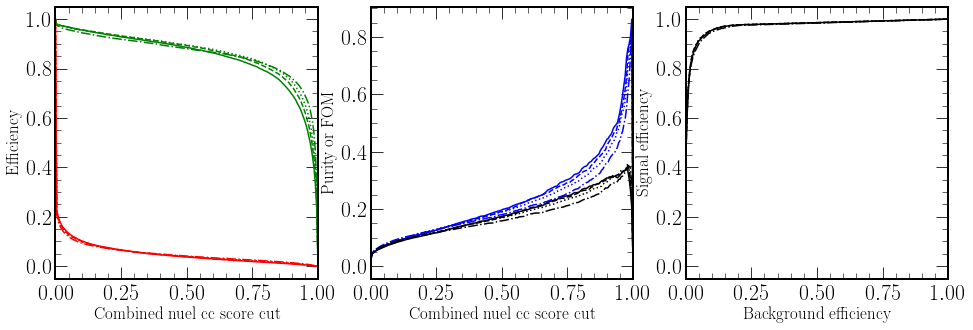

In [104]:
chipsnet.plotting.plot_curves([out_0[0], out_10[0], out_20[0], out_50[0]], save_path+"beam_calib_curves")

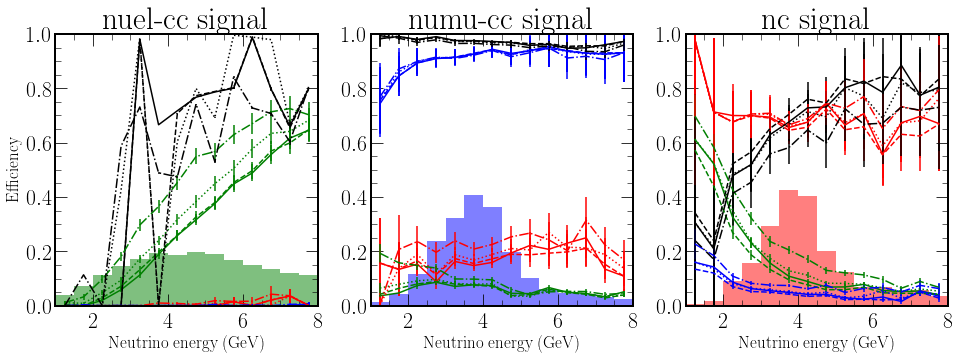

In [105]:
chipsnet.plotting.plot_e_hists([out_0[0], out_10[0], out_20[0], out_50[0]], ev_0, save_path+"beam_calib_hists")

In [106]:
chipsnet.utils.print_output_comparison([out_0[0], out_10[0], out_20[0], out_50[0]])

Max FOMs: 0.34312914778060355
Max FOM cuts: 0.975
Sig eff AUC: 0.8478803303694729
Bkg eff AUC: 0.050531291168310996
Purity AUC: 0.23502968150634468
FOM AUC: 0.1812527553132221
ROC AUC: 0.9740881136329113
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     27304
           1       0.97      0.94      0.95     27236
           2       0.73      0.77      0.75      9460

    accuracy                           0.91     64000
   macro avg       0.87      0.88      0.87     64000
weighted avg       0.91      0.91      0.91     64000

              precision    recall  f1-score   support

           0       0.43      0.70      0.53      4962
           1       0.51      0.44      0.47      8544
           2       0.72      0.69      0.71     10486
           3       0.12      0.29      0.17       322
           4       0.18      0.04      0.07      1203
           5       0.39      0.06      0.10      1787
           6       0.50      0.81   

In [107]:
# Tidy up
del ev_0, out_0
del ev_10, out_10
del ev_20, out_20
del ev_50, out_50

<a id='energy_calib'></a>

## Model calibration sensitivity: energy estimation (energy_calib)
* 1
* 2
* 3

In [ ]:
ev_0, out_0 = chipsnet.utils.predict_energies(config, "flux", ["nuel_cc_energy"])
ev_10, out_10 = chipsnet.utils.predict_energies(config, "flux_factor_10", ["nuel_cc_energy"])
ev_20, out_20 = chipsnet.utils.predict_energies(config, "flux_factor_20", ["nuel_cc_energy"])
ev_50, out_50 = chipsnet.utils.predict_energies(config, "flux_factor_50", ["nuel_cc_energy"])

In [ ]:
e_range = [[0, 8000], [0, 8000]]
e_bins = [40, 40]
fig, axs = plt.subplots(1, 4, figsize=(20, 4), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
axs[0].hist2d(v_cth_flux_ev[v_cth_flux_ev["t_comb_cat"] == 0]["t_nuEnergy"], v_cth_flux_ev[v_cth_flux_ev["t_comb_cat"] == 0]["nuel_cc_energy_pred_t_nuEnergy"],
              range=e_range, bins=e_bins, weights=v_cth_flux_ev[v_cth_flux_ev["t_comb_cat"] == 0]["w"], cmap="Reds")
axs[0].grid()
axs[0].label_outer()
axs[0].set(xlabel=r"True energy (MeV)", ylabel=r"Reco energy (MeV)")
axs[0].set_title(r"0")
axs[1].hist2d(v_cth_flux_10_ev[v_cth_flux_10_ev["t_comb_cat"] == 0]["t_nuEnergy"], v_cth_flux_10_ev[v_cth_flux_10_ev["t_comb_cat"] == 0]["nuel_cc_energy_pred_t_nuEnergy"],
              range=e_range, bins=e_bins, weights=v_cth_flux_10_ev[v_cth_flux_10_ev["t_comb_cat"] == 0]["w"], cmap="Reds")
axs[1].grid()
axs[1].label_outer()
axs[1].set(xlabel=r"True energy (MeV)")
axs[1].set_title(r"10")
axs[2].hist2d(v_cth_flux_20_ev[v_cth_flux_20_ev["t_comb_cat"] == 0]["t_nuEnergy"], v_cth_flux_20_ev[v_cth_flux_20_ev["t_comb_cat"] == 0]["nuel_cc_energy_pred_t_nuEnergy"],
              range=e_range, bins=e_bins, weights=v_cth_flux_20_ev[v_cth_flux_20_ev["t_comb_cat"] == 0]["w"], cmap="Reds")
axs[2].grid()
axs[2].label_outer()
axs[2].set(xlabel=r"True energy (MeV)")
axs[2].set_title(r"20")
axs[3].hist2d(v_cth_flux_50_ev[v_cth_flux_50_ev["t_comb_cat"] == 0]["t_nuEnergy"], v_cth_flux_50_ev[v_cth_flux_50_ev["t_comb_cat"] == 0]["nuel_cc_energy_pred_t_nuEnergy"],
              range=e_range, bins=e_bins, weights=v_cth_flux_50_ev[v_cth_flux_50_ev["t_comb_cat"] == 0]["w"], cmap="Reds")
axs[3].grid()
axs[3].label_outer()
axs[3].set(xlabel=r"True energy (MeV)")
axs[3].set_title(r"50")
chipsnet.plotting.save(save_path + "true_vs_reco_energy_comb")

In [ ]:
e_range = [[0, 8000], [0, 8000]]
e_bins = [40, 40]
fig, axs = plt.subplots(1, 4, figsize=(20, 4), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
e_list, std_list = frac_e_vs_e(v_cth_flux_ev)
axs[0].plot(e_list, std_list)
axs[0].grid()
axs[0].label_outer()
axs[0].set(xlabel=r"True energy (MeV)", ylabel=r"Reco energy (MeV)")
axs[0].set_title(r"0")
axs[0].set_ylim(0, 0.5)
e_list, std_list = frac_e_vs_e(v_cth_flux_10_ev)
axs[1].plot(e_list, std_list)
axs[1].grid()
axs[1].label_outer()
axs[1].set(xlabel=r"True energy (MeV)")
axs[1].set_title(r"10")
axs[1].set_ylim(0, 0.5)
e_list, std_list = frac_e_vs_e(v_cth_flux_20_ev)
axs[2].plot(e_list, std_list)
axs[2].grid()
axs[2].label_outer()
axs[2].set(xlabel=r"True energy (MeV)")
axs[2].set_title(r"20")
axs[2].set_ylim(0, 0.5)
e_list, std_list = frac_e_vs_e(v_cth_flux_50_ev)
axs[3].plot(e_list, std_list)
axs[3].grid()
axs[3].label_outer()
axs[3].set(xlabel=r"True energy (MeV)")
axs[3].set_title(r"50")
axs[3].set_ylim(0, 0.5)
chipsnet.plotting.save(save_path + "true_vs_reco_energy_comb")

In [ ]:
# Tidy up
del ev_0, out_0
del ev_10, out_10
del ev_20, out_20
del ev_50, out_50

<a id='cosmic_cluster'></a>

## Clustering: cosmic classification
* 1
* 2
* 3

In [136]:
u_ev, u_out = chipsnet.utils.process_ds(config, "uniform_cosmic", ["cosmic_vtx"], model_cats=["t_cosmic_cat"])
cosmic_events = u_ev[u_ev["t_cosmic_cat"] == 1][:5000]
beam_events = u_ev[u_ev["t_cosmic_cat"] == 0][:5000]
events = pd.concat([cosmic_events, beam_events]).sample(frac=1).reset_index(drop=True)

Processing uniform_cosmic... count    4.866400e+04
mean     5.336298e-04
std      2.081279e-02
min      1.534027e-12
25%      1.895402e-08
50%      2.327182e-07
75%      1.774150e-06
max      9.997981e-01
Name: cosmic_vtx_pred_t_cosmic_cat, dtype: float64
count    15336.000000
mean         0.998265
std          0.036169
min          0.000416
25%          0.999996
50%          0.999999
75%          0.999999
max          1.000000
Name: cosmic_vtx_pred_t_cosmic_cat, dtype: float64
took 44.83 seconds


In [138]:
pca_model = chipsnet.utils.model_from_conf(config, "cosmic_vtx")
events = chipsnet.utils.run_pca(events, pca_model, verbose=True, components=2, standardise=True)
cat_0_ev = events[events["t_cosmic_cat"] == 0]
cat_1_ev = events[events["t_cosmic_cat"] == 1]

Explained variation per principal component: [0.28420635 0.17856915]


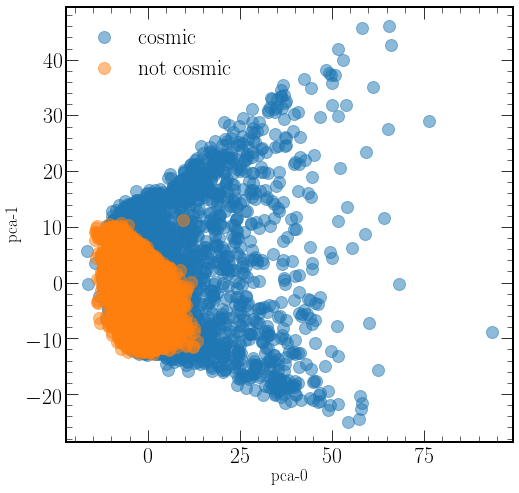

In [139]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_1_ev.pca_0, cat_1_ev.pca_1, marker='.', linestyle='', ms=12, label="cosmic", alpha=0.5)
axs.plot(cat_0_ev.pca_0, cat_0_ev.pca_1, marker='.', linestyle='', ms=12, label="not cosmic", alpha=0.5)
axs.legend()
axs.set_xlabel('pca-0', fontsize=17)
axs.set_ylabel('pca-1', fontsize=17)
chipsnet.plotting.save(save_path + "pca")

In [140]:
tsne_model = chipsnet.utils.model_from_conf(config, "cosmic_vtx")
events = chipsnet.utils.run_tsne(events, tsne_model, components=2, standardise=True, max_events=10000)
cat_0_ev = events[events["t_cosmic_cat"] == 0]
cat_1_ev = events[events["t_cosmic_cat"] == 1]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.884s...
[t-SNE] Computed neighbors for 10000 samples in 67.814s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.482492
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.018196
[t-SNE] KL divergence after 300 iterations: 2.599324


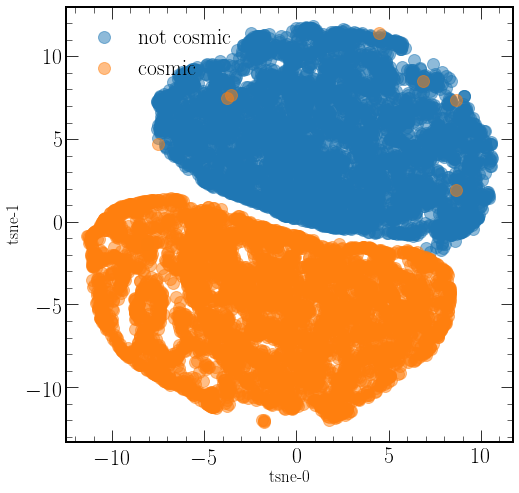

In [141]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.tsne_0, cat_0_ev.tsne_1, marker='.', linestyle='', ms=12, label="not cosmic", alpha=0.5)
axs.plot(cat_1_ev.tsne_0, cat_1_ev.tsne_1, marker='.', linestyle='', ms=12, label="cosmic", alpha=0.5)
axs.legend()
axs.set_xlabel('tsne-0', fontsize=17)
axs.set_ylabel('tsne-1', fontsize=17)
chipsnet.plotting.save(save_path + "tsne")

In [142]:
# Tidy up
del u_ev, u_out, events

<a id='beam_cluster'></a>

## Clustering: beam classification
* 1
* 2
* 3

In [143]:
u_ev, u_out = chipsnet.utils.process_ds(config, "uniform", ["beam_primaries"])
nuel_event = u_ev[u_ev["t_comb_cat"] == 0][:5000]
numu_events = u_ev[u_ev["t_comb_cat"] == 1][:5000]
nc_events = u_ev[u_ev["t_comb_cat"] == 2][:5000]
events = pd.concat([nuel_event, numu_events, nc_events]).sample(frac=1).reset_index(drop=True)

Processing uniform... took 73.86 seconds


In [144]:
pca_model = chipsnet.utils.model_from_conf(config, "beam_primaries")
events = chipsnet.utils.run_pca(events, pca_model, verbose=True, components=2, standardise=True)
cat_0_ev = events[events["t_comb_cat"] == 0]
cat_1_ev = events[events["t_comb_cat"] == 1]
cat_2_ev = events[events["t_comb_cat"] == 2]

Explained variation per principal component: [0.12875737 0.12252976]


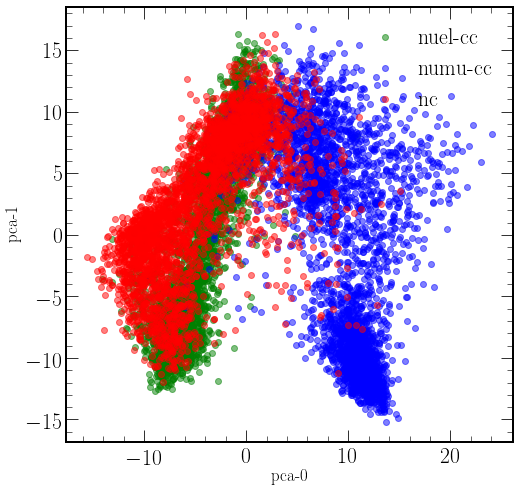

In [154]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.pca_0, cat_0_ev.pca_1, marker='.', linestyle='', ms=12, label="nuel-cc", alpha=0.5, color="green")
axs.plot(cat_1_ev.pca_0, cat_1_ev.pca_1, marker='.', linestyle='', ms=12, label="numu-cc", alpha=0.5, color="blue")
axs.plot(cat_2_ev.pca_0, cat_2_ev.pca_1, marker='.', linestyle='', ms=12, label="nc", alpha=0.5, color="red")
axs.legend()
axs.set_xlabel('pca-0', fontsize=17)
axs.set_ylabel('pca-1', fontsize=17)
chipsnet.plotting.save(save_path + "pca")

In [146]:
tsne_model = chipsnet.utils.model_from_conf(config, "beam_primaries")
events = chipsnet.utils.run_tsne(events, tsne_model, components=2, standardise=True, max_events=10000)
cat_0_ev = events[events.t_comb_cat == 0]
cat_1_ev = events[events.t_comb_cat == 1]
cat_2_ev = events[events.t_comb_cat == 2]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.840s...
[t-SNE] Computed neighbors for 10000 samples in 67.592s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 3.913263
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.780586
[t-SNE] KL divergence after 300 iterations: 2.610373


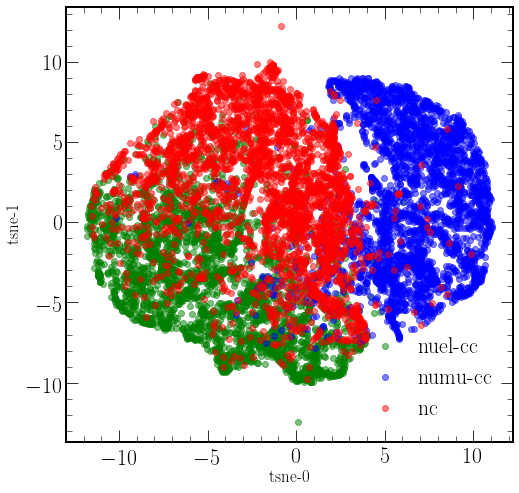

In [153]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.tsne_0, cat_0_ev.tsne_1, marker='.', linestyle='', ms=12, label="nuel-cc", alpha=0.5, color="green")
axs.plot(cat_1_ev.tsne_0, cat_1_ev.tsne_1, marker='.', linestyle='', ms=12, label="numu-cc", alpha=0.5, color="blue")
axs.plot(cat_2_ev.tsne_0, cat_2_ev.tsne_1, marker='.', linestyle='', ms=12, label="nc", alpha=0.5, color="red")
axs.legend()
axs.set_xlabel('tsne-0', fontsize=17)
axs.set_ylabel('tsne-1', fontsize=17)
chipsnet.plotting.save(save_path + "tsne")

In [155]:
# Tidy up
del u_ev, u_out, events

<a id='energy_cluster'></a>

## Clustering: energy estimation
* 1
* 2
* 3

In [ ]:
u_ev, u_out = chipsnet.utils.predict_energies(config, "uniform", ["beam_primaries"])

<a id='cosmic_explain'></a>

## Explanation: cosmic classification
* 1
* 2
* 3

<a id='beam_explain'></a>

## Explanation: beam classification
* 1
* 2
* 3

In [ ]:
explain_ev, explain_out = chipsnet.utils.process_ds(config, "stacked_noreco")

In [ ]:
grad_cam_model = chipsnet.utils.model_from_conf(config, "explain")
grad_cams_1 = chipsnet.utils.explain_gradcam(explain_ev, grad_cam_model, 10, output="t_nu_nc_cat", layer_name="block0_path0_conv1")
grad_cams_2 = chipsnet.utils.explain_gradcam(explain_ev, grad_cam_model, 10, output="t_nu_nc_cat", layer_name="block1_path0_conv1")
grad_cams_3 = chipsnet.utils.explain_gradcam(explain_ev, grad_cam_model, 10, output="t_nu_nc_cat", layer_name="block2_conv1")

In [ ]:
event = 2
fig, axs = plt.subplots(1, 3, figsize=(15, 12), gridspec_kw={'hspace': 0.3})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
axs[0].imshow(grad_cams_1[event], cmap='Reds', origin='lower')
axs[0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 1')
axs[1].imshow(grad_cams_2[event], cmap='Reds', origin='lower')
axs[1].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 2')
axs[2].imshow(grad_cams_3[event], cmap='Reds', origin='lower')
axs[2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 3')
chipsnet.plotting.save(save_path + "grad_cam")

In [ ]:
activation_model = chipsnet.utils.model_from_conf(config, "explain")
activations_1 = chipsnet.utils.explain_activation(explain_ev, activation_model, 10, output="t_nu_nc_cat", layer_name="block0_path0_conv1")
activations_2 = chipsnet.utils.explain_activation(explain_ev, activation_model, 10, output="t_nu_nc_cat", layer_name="block1_path0_conv1")
activations_3 = chipsnet.utils.explain_activation(explain_ev, activation_model, 10, output="t_nu_nc_cat", layer_name="block2_conv1")

In [ ]:
event = 1
fig, axs = plt.subplots(3, 1, figsize=(8, 24))
plt.rc('grid', linestyle="-", color='black')

axs[0].set_xticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_yticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_xticklabels('')
axs[0].set_yticklabels('')
extent = (0, 256, 256, 0)
axs[0].imshow(activations_1[event], cmap='Reds', origin='lower', extent=extent)
axs[0].set_title('Block 1 Activations')
axs[0].grid()

extent = (0, 192, 192, 0)
axs[1].set_xticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_yticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')
axs[1].imshow(activations_2[event], cmap='Reds', origin='lower', extent=extent)
axs[1].set_title('Block 2 Activations')
axs[1].grid()

extent = (0, 128, 128, 0)
axs[2].set_xticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_yticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_xticklabels('')
axs[2].set_yticklabels('')
axs[2].imshow(activations_3[event], cmap='Reds', origin='lower', extent=extent)
axs[2].set_title('Block 3 Activations')
axs[2].grid()

chipsnet.plotting.save(save_path + "activations")

In [ ]:
# Tidy up
del explain_ev, explain_out

<a id='energy_explain'></a>

## Explanation: energy estimation
* 1
* 2
* 3